In [ ]:
!pip install yellowbrick

In [ ]:
!pip install SMOTE
!pip install imblearn

In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import gc

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from concurrent.futures import ThreadPoolExecutor

from yellowbrick.classifier import ConfusionMatrix

import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [3]:
def convert_to_integer(value): # Function to cover the cases where there are multiple dbm_antsignal values.
    if pd.isna(value) or value == '':
        return None
    elif isinstance(value, int) or isinstance(value, float):
        return value
    else:
        signal_strengths = [int(v) for v in value.split('-') if v]
        if signal_strengths:
            average_strength = round(sum(signal_strengths) / len(signal_strengths))
            return -average_strength
        else:
            return None

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [7]:
selected_features = ['frame.len', 'radiotap.length', 'radiotap.dbm_antsignal', 'wlan.duration', 'radiotap.present.tsft', 'radiotap.channel.freq', 'radiotap.channel.flags.cck', 'radiotap.channel.flags.ofdm', 'wlan.fc.type', 'wlan.fc.subtype', 'wlan.fc.ds', 'wlan.fc.frag', 'wlan.fc.retry', 'wlan.fc.pwrmgt', 'wlan.fc.moredata', 'wlan.fc.protected']
main_folder_path = "/content/drive/MyDrive/AWID/CSV"
columns_to_read = selected_features + ['Label']
included_directories = ["1.Deauth", "2.Disas", "3.(Re)Assoc", "6.Kr00k", "4.Rogue_AP", "12.Evil_Twin", "5.Krack"]

csv_files = glob.glob(f"{main_folder_path}/**/*.csv", recursive=True)

def read_csv(file):
    return pd.read_csv(file, usecols=columns_to_read)

# Use ThreadPoolExecutor for parallel file reading
with ThreadPoolExecutor(max_workers=2) as executor:  # Adjust max_workers based on your CPU
    dfs = list(executor.map(read_csv, [file for directory in included_directories for file in glob.glob(f"{main_folder_path}/{directory}/*.csv")]))

# Concatenate all DataFrames
data = pd.concat(dfs, ignore_index=True)

In [8]:
del dfs
del csv_files
data = reduce_mem_usage(data)

Memory usage of dataframe is 1942.25 MB
Memory usage after optimization is: 814.11 MB
Decreased by 58.1%


In [ ]:
data

,frame.len,radiotap.channel.flags.cck,radiotap.channel.flags.ofdm,radiotap.channel.freq,radiotap.dbm_antsignal,radiotap.length,radiotap.present.tsft,wlan.duration,wlan.fc.ds,wlan.fc.frag,wlan.fc.moredata,wlan.fc.protected,wlan.fc.pwrmgt,wlan.fc.type,wlan.fc.retry,wlan.fc.subtype,Label
0,342.0,0.0,1.0,5180.0,-34-37-34,56.0,1-0-0,0.0,0x00000000,0.0,0.0,0.0,0.0,0.0,0.0,8.0,Normal
1,342.0,0.0,1.0,5180.0,-34-38-34,56.0,1-0-0,0.0,0x00000000,0.0,0.0,0.0,0.0,0.0,0.0,8.0,Normal
2,136.0,0.0,1.0,5180.0,-34-39-34,56.0,1-0-0,0.0,0x00000002,0.0,0.0,1.0,0.0,2.0,0.0,0.0,Normal
3,154.0,0.0,1.0,5180.0,-34-39-34,56.0,1-0-0,0.0,0x00000002,0.0,0.0,1.0,0.0,2.0,0.0,0.0,Normal
4,342.0,0.0,1.0,5180.0,-35-40-35,56.0,1-0-0,0.0,0x00000000,0.0,0.0,0.0,0.0,0.0,0.0,8.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14974941,1602.0,0.0,0.0,2472.0,-99,56.0,0-0-0,48.0,0x00000002,0.0,0.0,1.0,0.0,2.0,0.0,8.0,Normal
14974942,1602.0,0.0,0.0,2472.0,-99,56.0,0-0-0,48.0,0x00000002,0.0,0.0,1.0,0.0,2.0,0.0,8.0,Normal
14974943,1602.0,0.0,0.0,2472.0,-99,56.0,0-0-0,48.0,0x00000002,0.0,0.0,1.0,0.0,2.0,0.0,8.0,Normal
14974944,88.0,0.0,1.0,2472.0,-162,56.0,1-0-0,0.0,0x00000000,0.0,0.0,0.0,0.0,1.0,0.0,9.0,Normal


In [9]:
data = data.replace(r'^\s*$', pd.NA, regex=True)
data = data.replace('?', pd.NA)
data = data.dropna()

In [10]:
data['Label'] = data['Label'].replace('Kr00K', 'Kr00k')

<ipython-input-10-1608245824>:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data['Label'] = data['Label'].replace('Kr00K', 'Kr00k')
<ipython-input-10-1608245824>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Label'] = data['Label'].replace('Kr00K', 'Kr00k')


In [ ]:
value_counts = data['Label'].value_counts()
value_counts

,count
Label,
Normal,14563586
Kr00k,135568
Evil_Twin,104827
Disas,75131
Krack,49990
Deauth,38942
(Re)Assoc,5502
RogueAP,1310


In [11]:
number_to_delete = 12_600_000
normal_indices = data[data['Label'] == 'Normal'].index
indices_to_delete = pd.Series(normal_indices).sample(n=number_to_delete, random_state=42)
data = data.drop(indices_to_delete)

In [ ]:
value_counts = data['Label'].value_counts()
value_counts

,count
Label,
Normal,1963586
Kr00k,135568
Evil_Twin,104827
Disas,75131
Krack,49990
Deauth,38942
(Re)Assoc,5502
RogueAP,1310


In [12]:
X = data.loc[:, selected_features]
y = data[['Label']]

In [13]:
del data

In [14]:
X['radiotap.dbm_antsignal'] = X['radiotap.dbm_antsignal'].apply(convert_to_integer)

In [15]:
columns_to_scale = ['frame.len', 'radiotap.length', 'radiotap.dbm_antsignal', 'wlan.duration']
columns_to_one_hot_encode = [col for col in X.columns if col not in columns_to_scale]

# Min-max scaling
scaler = MinMaxScaler()
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

# One-hot encoding
X = pd.get_dummies(X, columns=columns_to_one_hot_encode)

In [16]:
memory_usage = X.memory_usage(deep=True)
total_memory_usage = memory_usage.sum()
output = total_memory_usage / (1024 ** 2)

print(f"{output:.2f} MB")

181.19 MB


In [17]:
def evaluate_classifier(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)

    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=1)
    recall_micro = recall_score(y_test, y_pred, average='micro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    auc_micro = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='micro')

    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=1)
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    auc_macro = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')

    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall_weighted = recall_score(y_test, y_pred, average='weighted')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    auc_weighted = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')

    accuracy = accuracy_score(y_test, y_pred)

    classes = ["(Re)Assoc", "Deauth", "Disas", "Evil_Twin", "Kr00k", "Krack", "Normal", "RogueAP"]
    cm = confusion_matrix(y_test, y_pred)

    results = [
        [precision_micro, recall_micro, f1_micro, auc_micro],
        [precision_macro, recall_macro, f1_macro, auc_macro],
        [precision_weighted, recall_weighted, f1_weighted, auc_weighted],
        accuracy,
        cm
    ]

    return results

In [18]:
def evaluate_classifier_linearsvc(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)

    decision_scores = classifier.decision_function(X_test)

    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=1)
    recall_micro = recall_score(y_test, y_pred, average='micro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    auc_micro = roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), decision_scores, multi_class='ovr', average='micro')

    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=1)
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    auc_macro = roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), decision_scores, multi_class='ovr', average='macro')

    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall_weighted = recall_score(y_test, y_pred, average='weighted')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    auc_weighted = roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), decision_scores, multi_class='ovr', average='weighted')

    accuracy = accuracy_score(y_test, y_pred)

    classes = ["(Re)Assoc", "Deauth", "Disas", "Evil_Twin", "Kr00k", "Krack", "Normal", "RogueAP"]
    cm = confusion_matrix(y_test, y_pred)

    results = [
        [precision_micro, recall_micro, f1_micro, auc_micro],
        [precision_macro, recall_macro, f1_macro, auc_macro],
        [precision_weighted, recall_weighted, f1_weighted, auc_weighted],
        accuracy,
        cm
    ]

    return results

In [19]:
def train_and_eval_logistic_regression(X_train, y_train, X_test, y_test):
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    logreg_model = LogisticRegression(
        solver='sag',
        max_iter=500,
        tol=0.01,
        random_state=42,
        n_jobs=-1
    )

    logreg_model.fit(X_train, y_train)

    return evaluate_classifier(logreg_model, X_test, y_test)

In [20]:
def train_and_eval_sgdclassifier(X_train, y_train, X_test, y_test):
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    sgd_model = SGDClassifier(
        tol=1e-05,
        loss='modified_huber',
        early_stopping=True,
        n_jobs=-1,
        random_state=42
    )

    sgd_model.fit(X_train, y_train)

    return evaluate_classifier(sgd_model, X_test, y_test)

In [21]:
def train_and_eval_linearsvc(X_train, y_train, X_test, y_test):
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    svc_model = LinearSVC(max_iter=20000, C=1.5, random_state=42)

    svc_model.fit(X_train, y_train)

    return evaluate_classifier_linearsvc(svc_model, X_test, y_test)

In [22]:
def train_and_eval_lightgbm(X_train, y_train, X_test, y_test):
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    params = {
        'objective': 'multiclass',
        'num_class': len(y_train.unique()),
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.01,
        'max_bin': 20,
        'max_depth': 10,
        'min_child_samples': 30,
        'min_data_in_bin': 10,
        'min_split_gain': 0.1,
        'n_estimators': 80,
        'reg_alpha': 0.01,
        'reg_lambda': 0.01,
        'n_jobs': -1,
        'verbose': -1
    }

    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(X_train, y_train)

    return evaluate_classifier(lgb_model, X_test, y_test)

In [23]:
def train_and_eval_decision_tree(X_train, y_train, X_test, y_test):
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    dt_model = DecisionTreeClassifier(
        max_depth=20,
        ccp_alpha=0.001,
        max_leaf_nodes=100,
        min_samples_leaf=2,
        random_state=42
    )

    dt_model.fit(X_train, y_train)

    return evaluate_classifier(dt_model, X_test, y_test)

In [24]:
def train_and_eval_random_forest(X_train, y_train, X_test, y_test):
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    rf_model = RandomForestClassifier(
        max_depth=20,
        ccp_alpha=0.001,
        max_leaf_nodes=100,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(X_train, y_train)

    return evaluate_classifier(rf_model, X_test, y_test)

In [25]:
def train_and_eval_extra_trees(X_train, y_train, X_test, y_test):
    y_train = y_train['Label'].astype('category').cat.codes
    y_test = y_test['Label'].astype('category').cat.codes

    et_model = ExtraTreesClassifier(
        max_depth=200,
        n_estimators=200,
        ccp_alpha=0.0001,
        max_leaf_nodes=500,
        min_samples_leaf=2,
        min_samples_split=10,
        random_state=42,
        n_jobs=-1
    )

    et_model.fit(X_train, y_train)

    return evaluate_classifier(et_model, X_test, y_test)

In [26]:
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(10, 10))

    #vmax = 320000
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

In [27]:
def print_results(name, results):
    classes = ["(Re)Assoc", "Deauth", "Disas", "Evil_Twin", "Kr00k", "Krack", "Normal", "RogueAP"]
    print(f"\n{name}")

    print(f"Micro Precision: {results[0][0]}")
    print(f"Micro Recall: {results[0][1]}")
    print(f"Micro F1: {results[0][2]}")
    print(f"Micro AUC: {results[0][3]}")

    print(f"Macro Precision: {results[1][0]}")
    print(f"Macro Recall: {results[1][1]}")
    print(f"Macro F1: {results[1][2]}")
    print(f"Macro AUC: {results[1][3]}")

    print(f"Weighted Precision: {results[2][0]}")
    print(f"Weighted Recall: {results[2][1]}")
    print(f"Weighted F1: {results[2][2]}")
    print(f"Weighted AUC: {results[2][3]}")

    print(f"Accuracy: {results[3]}")

    plot_confusion_matrix(results[4], classes, f'Combined Confusion Matrix for {name}')

In [28]:
def print_average_results(name, results_list):
    classes = ["(Re)Assoc", "Deauth", "Disas", "Evil_Twin", "Kr00k", "Krack", "Normal", "RogueAP"]
    print(f"\n{name}")

    average_precision_micro = sum(result[0][0] for result in results_list) / len(results_list)
    average_recall_micro = sum(result[0][1] for result in results_list) / len(results_list)
    average_f1_micro = sum(result[0][2] for result in results_list) / len(results_list)
    average_auc_micro = sum(result[0][3] for result in results_list) / len(results_list)

    average_precision_macro = sum(result[1][0] for result in results_list) / len(results_list)
    average_recall_macro = sum(result[1][1] for result in results_list) / len(results_list)
    average_f1_macro = sum(result[1][2] for result in results_list) / len(results_list)
    average_auc_macro = sum(result[1][3] for result in results_list) / len(results_list)

    average_precision_weighted = sum(result[2][0] for result in results_list) / len(results_list)
    average_recall_weighted = sum(result[2][1] for result in results_list) / len(results_list)
    average_f1_weighted = sum(result[2][2] for result in results_list) / len(results_list)
    average_auc_weighted = sum(result[2][3] for result in results_list) / len(results_list)

    average_accuracy = sum(result[3] for result in results_list) / len(results_list)

    combined_cm = None

    # Add each confusion matrix
    for result in results_list:
        if combined_cm is None:
            combined_cm = result[4]
        else:
            combined_cm += result[4]

    print("Average Micro Precision:", average_precision_micro)
    print("Average Micro Recall:", average_recall_micro)
    print("Average Micro F1:", average_f1_micro)
    print("Average Micro AUC:", average_auc_micro)

    print("\nAverage Macro Precision:", average_precision_macro)
    print("Average Macro Recall:", average_recall_macro)
    print("Average Macro F1:", average_f1_macro)
    print("Average Macro AUC:", average_auc_macro)

    print("\nAverage Weighted Precision:", average_precision_weighted)
    print("Average Weighted Recall:", average_recall_weighted)
    print("Average Weighted F1:", average_f1_weighted)
    print("Average Weighted AUC:", average_auc_weighted)

    print("\nAverage Accuracy:", average_accuracy)

    plot_confusion_matrix(combined_cm, classes, f'Combined Confusion Matrix for {name}')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [30]:
#under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
#X_train, y_train = under_sampler.fit_resample(X_train, y_train)

In [31]:
#value_counts = y_train['Label'].value_counts()
#value_counts

In [32]:
smote = SMOTE(sampling_strategy="not majority", random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


Logistic Regression
Micro Precision: 0.9733121110297028
Micro Recall: 0.9733121110297028
Micro F1: 0.9733121110297028
Micro AUC: 0.9995288702595824
Macro Precision: 0.8021174327198769
Macro Recall: 0.9237298529176928
Macro F1: 0.837305368624028
Macro AUC: 0.9979041971728314
Weighted Precision: 0.9751350520696893
Weighted Recall: 0.9733121110297028
Weighted F1: 0.972228318312798
Weighted AUC: 0.9987488064671892
Accuracy: 0.9733121110297028


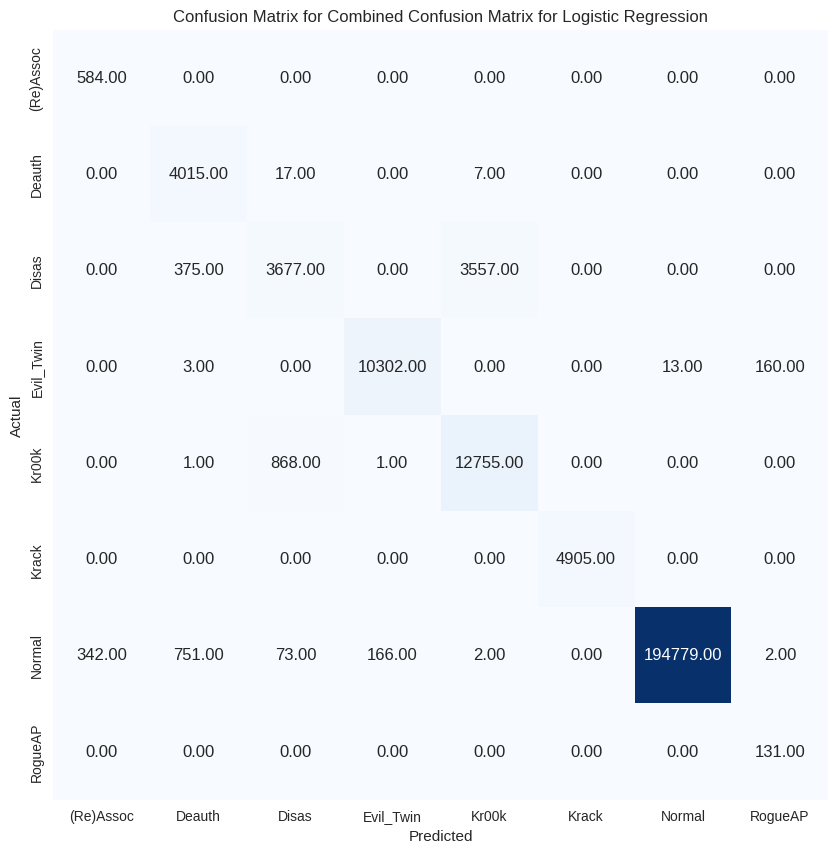

In [ ]:
results = train_and_eval_logistic_regression(X_train, y_train, X_test, y_test)
print_results("Logistic Regression", results)


SGDClassifier
Micro Precision: 0.9655684966692774
Micro Recall: 0.9655684966692774
Micro F1: 0.9655684966692774
Micro AUC: 0.998581786104222
Macro Precision: 0.7742682625974243
Macro Recall: 0.8959126501037734
Macro F1: 0.7863131949347886
Macro AUC: 0.9940413209140906
Weighted Precision: 0.9687689475325683
Weighted Recall: 0.9655684966692774
Weighted F1: 0.9656256503352888
Weighted AUC: 0.9982575315653262
Accuracy: 0.9655684966692774


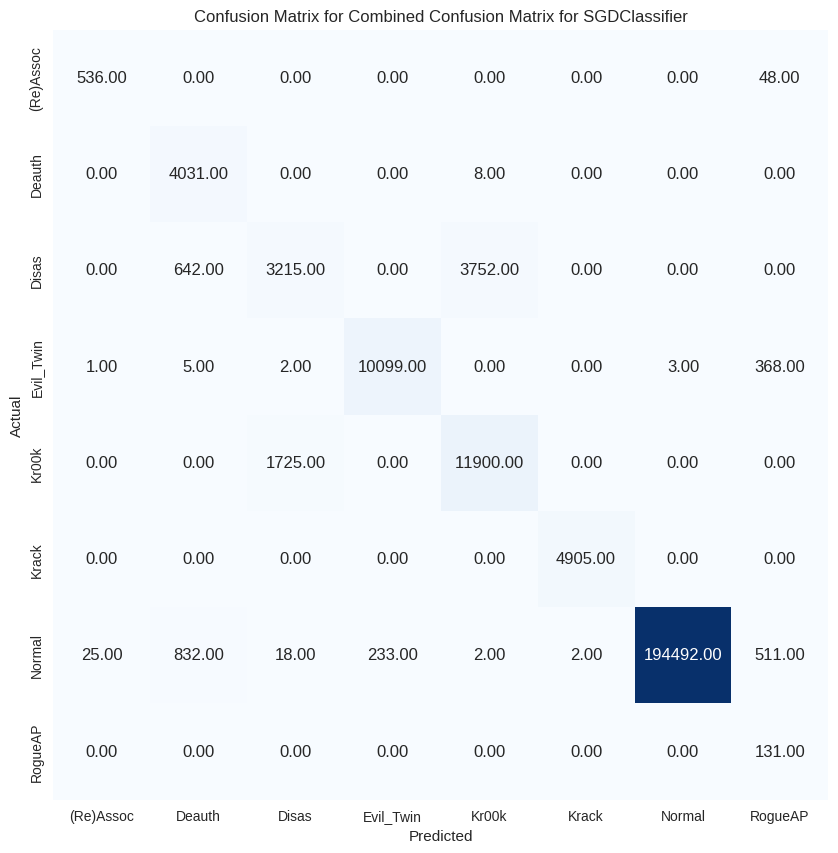

In [ ]:
results = train_and_eval_sgdclassifier(X_train, y_train, X_test, y_test)
print_results("SGDClassifier", results)


LinearSVC
Micro Precision: 0.9692950321282097
Micro Recall: 0.9692950321282097
Micro F1: 0.9692950321282097
Micro AUC: 0.9992084132133816
Macro Precision: 0.7561245022811577
Macro Recall: 0.9116724093064645
Macro F1: 0.7868825243097067
Macro AUC: 0.9971160253609259
Weighted Precision: 0.972685525882456
Weighted Recall: 0.9692950321282097
Weighted F1: 0.9680086894983743
Weighted AUC: 0.9990963892605013
Accuracy: 0.9692950321282097


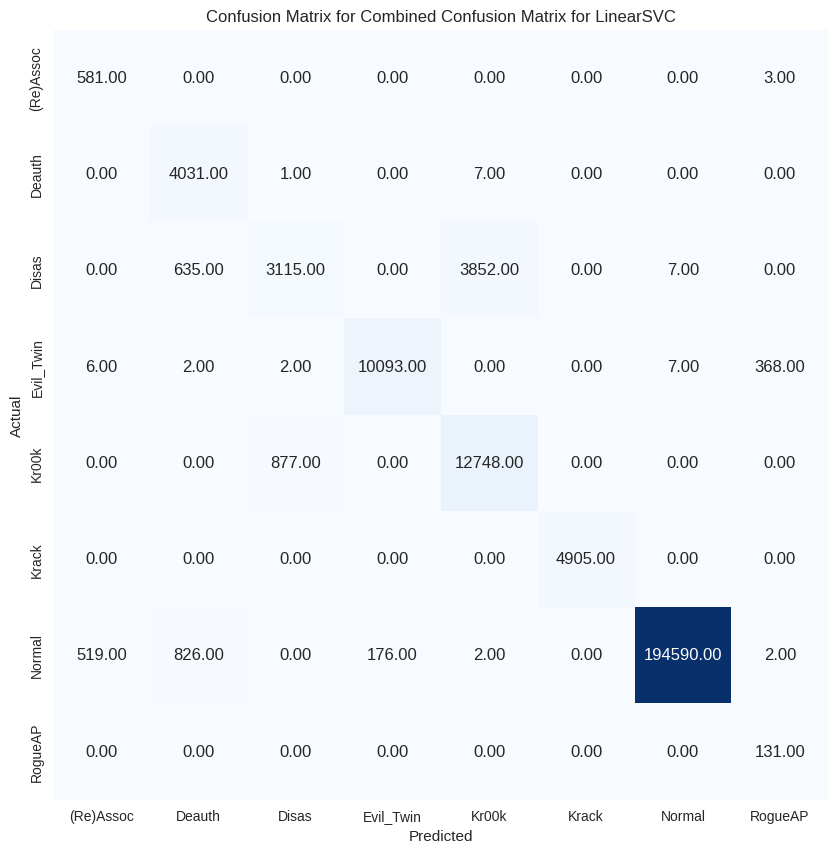

In [ ]:
results = train_and_eval_linearsvc(X_train, y_train, X_test, y_test)
print_results("LinearSVC", results)


LightGBM
Micro Precision: 0.9916289802346243
Micro Recall: 0.9916289802346243
Micro F1: 0.9916289802346243
Micro AUC: 0.9999385755194926
Macro Precision: 0.9679251791697828
Macro Recall: 0.9853531236670017
Macro F1: 0.9763845642731434
Macro AUC: 0.9996989839519023
Weighted Precision: 0.9920593483141891
Weighted Recall: 0.9916289802346243
Weighted F1: 0.9917846505843237
Weighted AUC: 0.9998926474994936
Accuracy: 0.9916289802346243


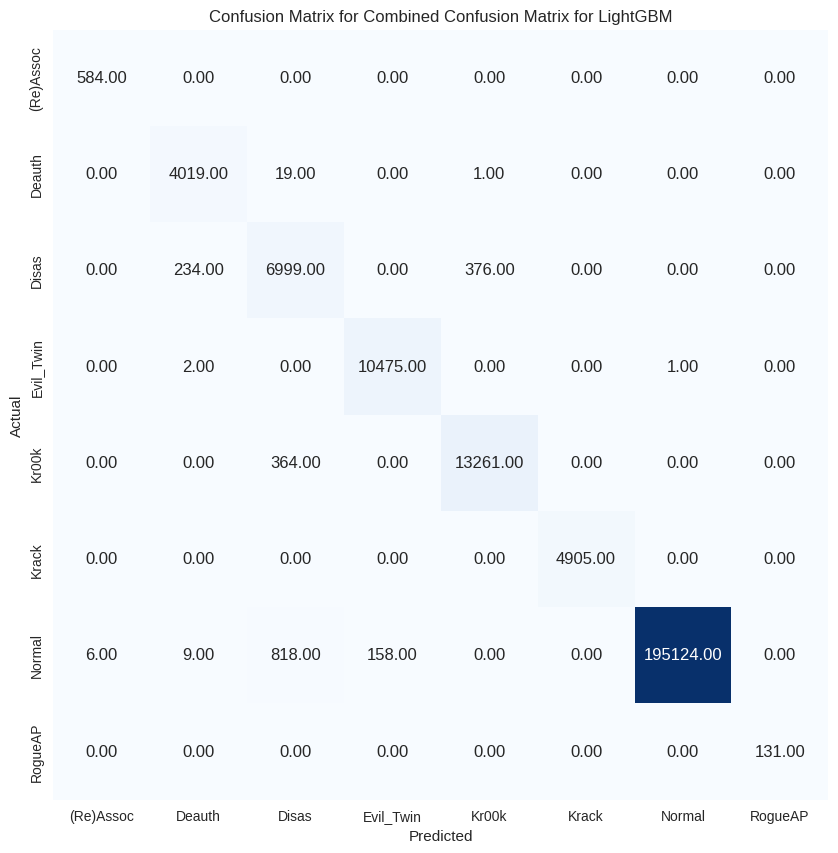

In [ ]:
results = train_and_eval_lightgbm(X_train, y_train, X_test, y_test)
print_results("LightGBM", results)


Decision Tree
Micro Precision: 0.9887951289760238
Micro Recall: 0.9887951289760238
Micro F1: 0.9887951289760238
Micro AUC: 0.9996582356269723
Macro Precision: 0.890107892087308
Macro Recall: 0.9840616699295599
Macro F1: 0.9226359483853028
Macro AUC: 0.9993096268045781
Weighted Precision: 0.9912400023627167
Weighted Recall: 0.9887951289760238
Weighted F1: 0.9895781257457231
Weighted AUC: 0.9994410397768574
Accuracy: 0.9887951289760238


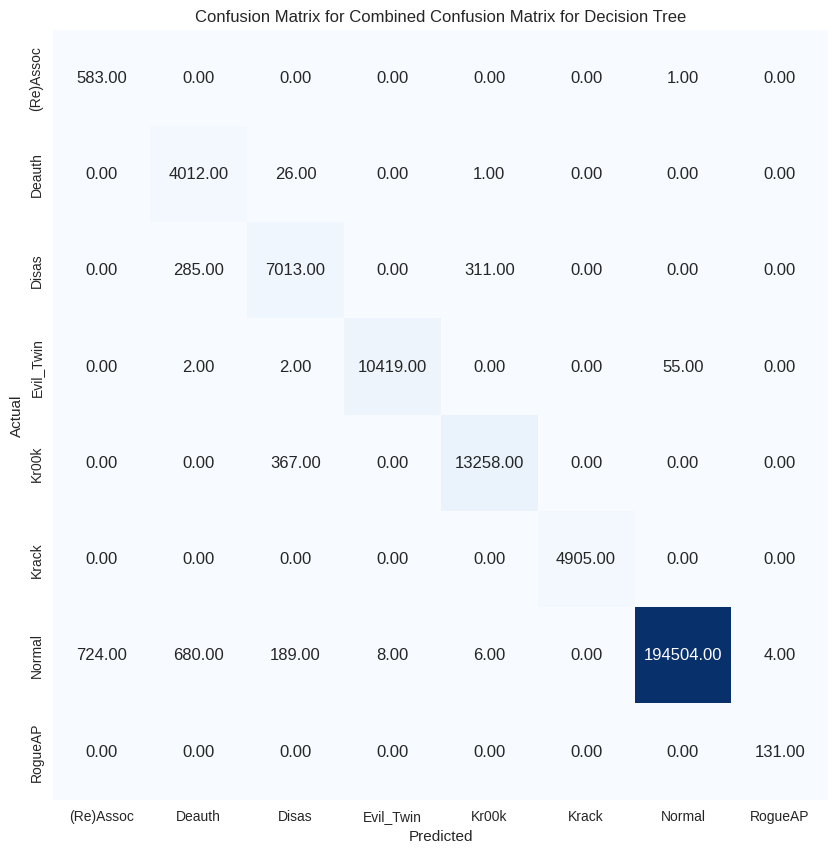

In [ ]:
results = train_and_eval_decision_tree(X_train, y_train, X_test, y_test)
print_results("Decision Tree", results)


Random Forest
Micro Precision: 0.9871613484584354
Micro Recall: 0.9871613484584354
Micro F1: 0.9871613484584354
Micro AUC: 0.999677063962062
Macro Precision: 0.8932601447088562
Macro Recall: 0.9813950058883514
Macro F1: 0.9256827871340103
Macro AUC: 0.9994733297010373
Weighted Precision: 0.9896027870702075
Weighted Recall: 0.9871613484584354
Weighted F1: 0.9878425356460384
Weighted AUC: 0.9997699252280452
Accuracy: 0.9871613484584354


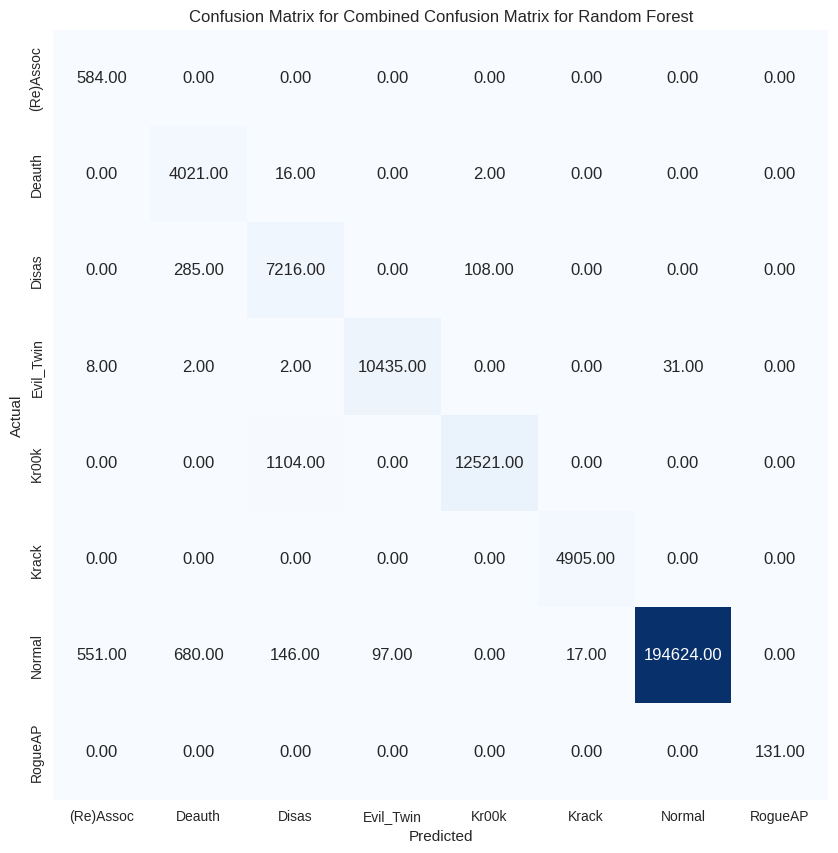

In [ ]:
results = train_and_eval_random_forest(X_train, y_train, X_test, y_test)
print_results("Random Forest", results)


Extra Trees
Micro Precision: 0.990247846188828
Micro Recall: 0.990247846188828
Micro F1: 0.990247846188828
Micro AUC: 0.9998422260371058
Macro Precision: 0.9543021435560299
Macro Recall: 0.9820036624797688
Macro F1: 0.9666312455189613
Macro AUC: 0.9993755474404087
Weighted Precision: 0.9911015700237401
Weighted Recall: 0.990247846188828
Weighted F1: 0.9904459392934746
Weighted AUC: 0.9998125575266126
Accuracy: 0.990247846188828


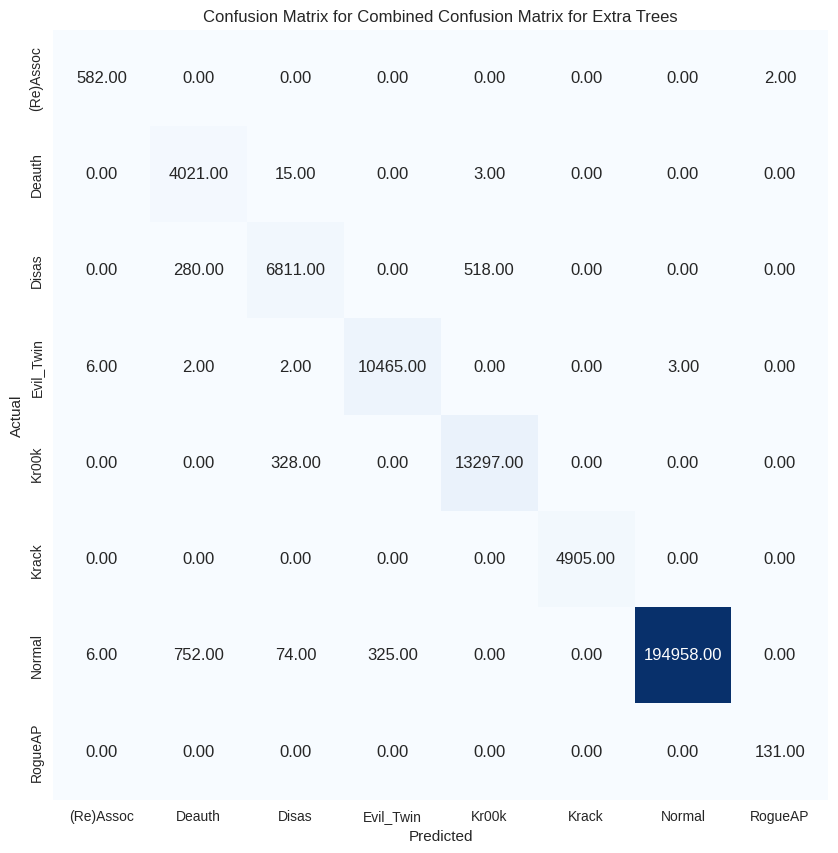

In [ ]:
results = train_and_eval_extra_trees(X_train, y_train, X_test, y_test)
print_results("Extra Trees", results)

In [ ]:
k_folds = 10
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)


Logistic Regression
Average Micro Precision: 0.9725680210243638
Average Micro Recall: 0.9725680210243638
Average Micro F1: 0.9725680210243638
Average Micro AUC: 0.9997276908458232

Average Macro Precision: 0.9095050267008309
Average Macro Recall: 0.7783256406901763
Average Macro F1: 0.7713693803118841
Average Macro AUC: 0.9980884894181334

Average Weighted Precision: 0.9731109685774465
Average Weighted Recall: 0.9725680210243638
Average Weighted F1: 0.9700192095729536
Average Weighted AUC: 0.9993182783944474

Average Accuracy: 0.9725680210243638


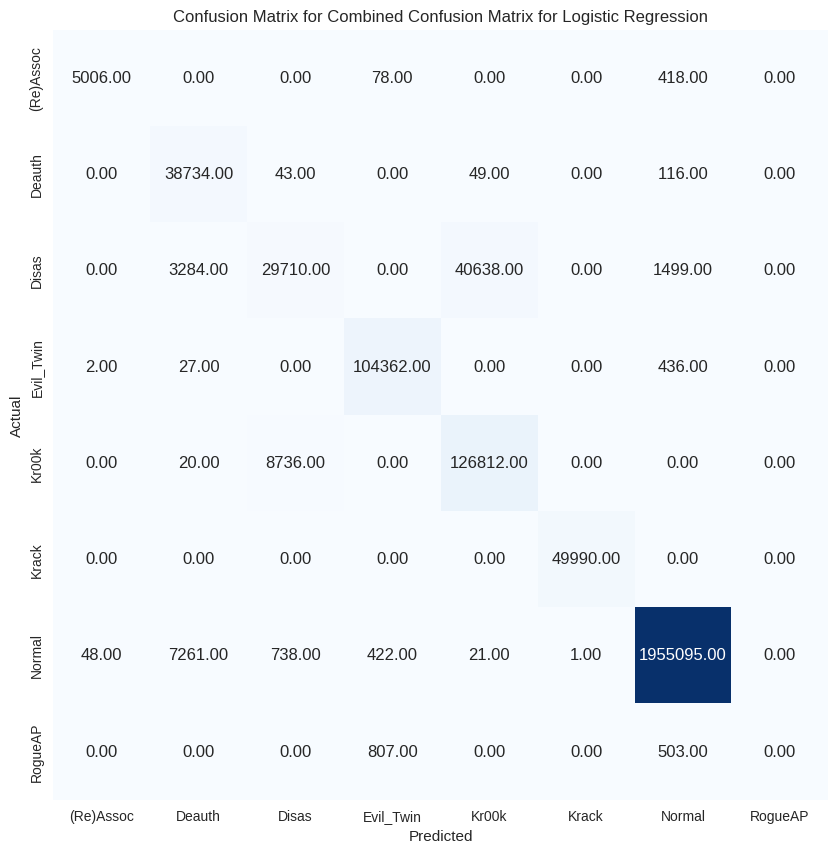

In [ ]:
results_list = []

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    results = train_and_eval_logistic_regression(X_train, y_train, X_test, y_test)

    results_list.append(results)

print_average_results("Logistic Regression", results_list)


SGDClassifier
Average Micro Precision: 0.9716787041759112
Average Micro Recall: 0.9716787041759112
Average Micro F1: 0.9716787041759112
Average Micro AUC: 0.9988270169010803

Average Macro Precision: 0.902112808924665
Average Macro Recall: 0.7759817211040041
Average Macro F1: 0.7641761746763408
Average Macro AUC: 0.9936232835034025

Average Weighted Precision: 0.972821929898269
Average Weighted Recall: 0.9716787041759112
Average Weighted F1: 0.9689605912184958
Average Weighted AUC: 0.9983210442897814

Average Accuracy: 0.9716787041759112


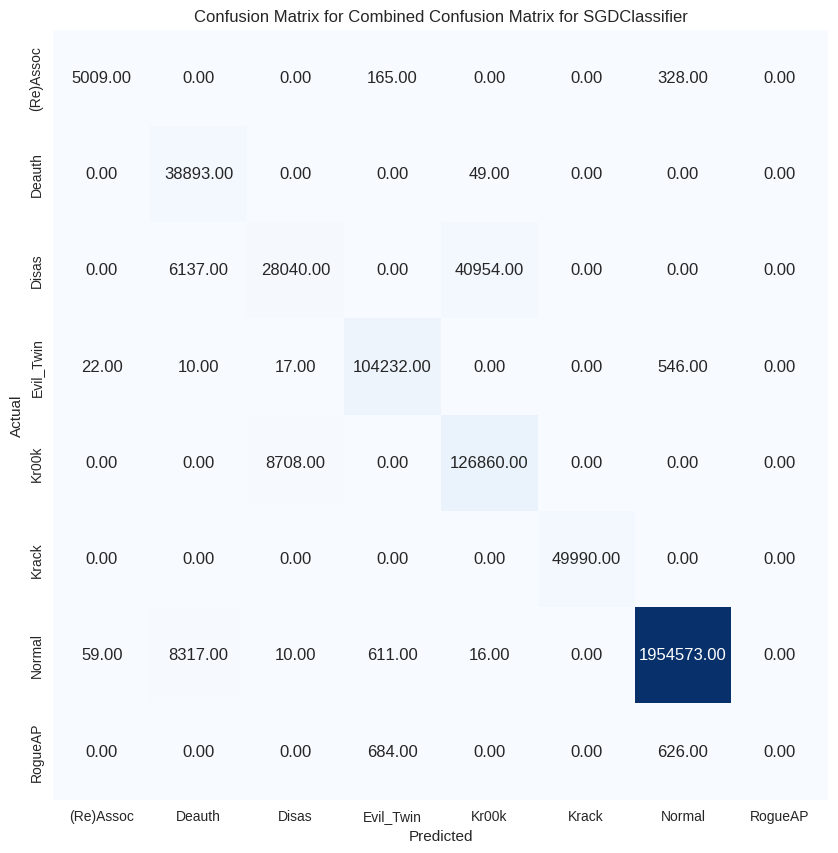

In [ ]:
results_list = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    results = train_and_eval_sgdclassifier(X_train, y_train, X_test, y_test)

    results_list.append(results)

print_average_results("SGDClassifier", results_list)


LinearSVC
Average Micro Precision: 0.9721469427468998
Average Micro Recall: 0.9721469427468998
Average Micro F1: 0.9721469427468998
Average Micro AUC: 0.9995321392549446

Average Macro Precision: 0.9084054805835631
Average Macro Recall: 0.7761843422286437
Average Macro F1: 0.7683213791797254
Average Macro AUC: 0.9973568282676977

Average Weighted Precision: 0.9727041548441957
Average Weighted Recall: 0.9721469427468998
Average Weighted F1: 0.9692630874141768
Average Weighted AUC: 0.9991549718726466

Average Accuracy: 0.9721469427468998


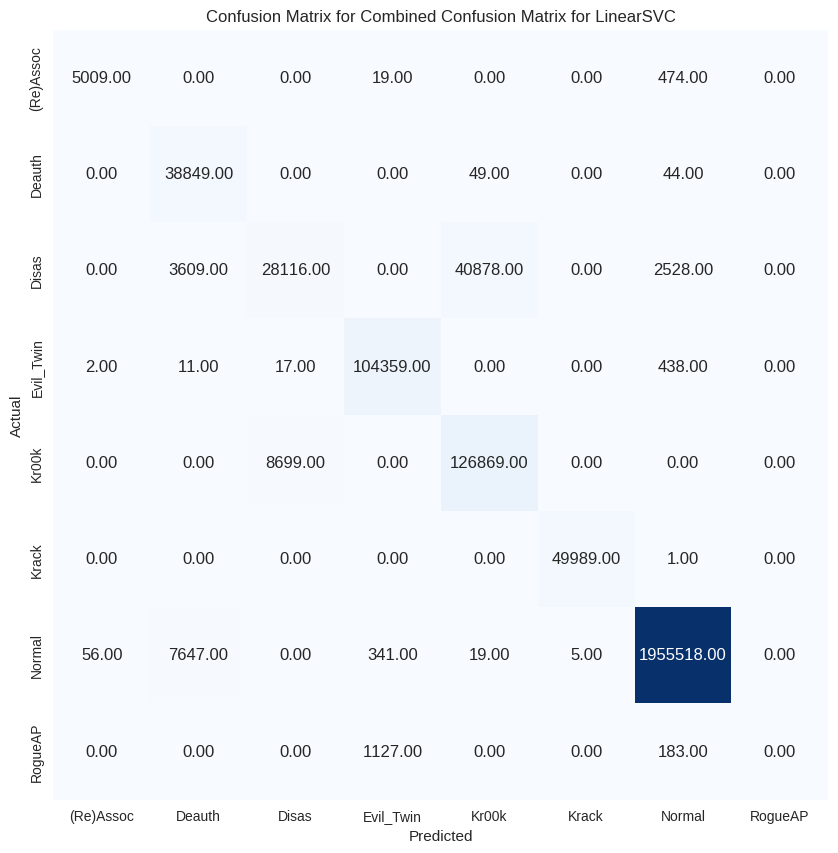

In [ ]:
results_list = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    results = train_and_eval_linearsvc(X_train, y_train, X_test, y_test)

    results_list.append(results)

print_average_results("LinearSVC", results_list)


LightGBM
Average Micro Precision: 0.9925801819100022
Average Micro Recall: 0.9925801819100022
Average Micro F1: 0.9925801819100022
Average Micro AUC: 0.9997390851230517

Average Macro Precision: 0.9427230631622863
Average Macro Recall: 0.9257578906056081
Average Macro F1: 0.9321185526839928
Average Macro AUC: 0.9994732166269908

Average Weighted Precision: 0.992713737545342
Average Weighted Recall: 0.9925801819100022
Average Weighted F1: 0.9923657549640545
Average Weighted AUC: 0.9998371400408013

Average Accuracy: 0.9925801819100022


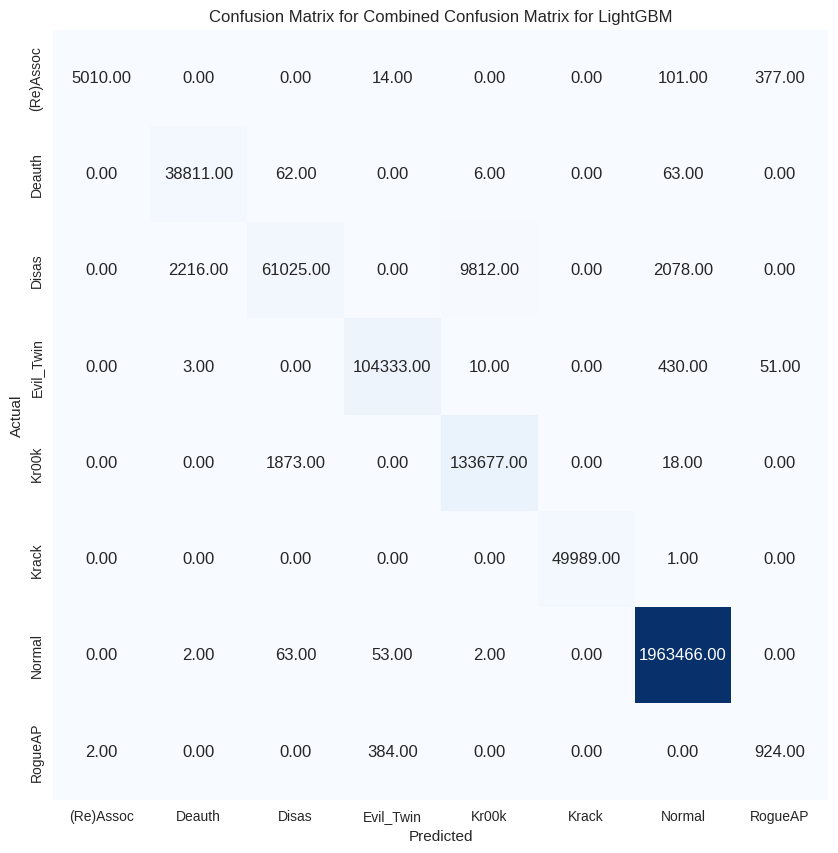

In [ ]:
results_list = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    results = train_and_eval_lightgbm(X_train, y_train, X_test, y_test)

    results_list.append(results)

print_average_results("LightGBM", results_list)


Decision Tree
Average Micro Precision: 0.9933494915868349
Average Micro Recall: 0.9933494915868349
Average Micro F1: 0.9933494915868349
Average Micro AUC: 0.9999486882964577

Average Macro Precision: 0.9791389593627023
Average Macro Recall: 0.8422705891499987
Average Macro F1: 0.8472875900183199
Average Macro AUC: 0.9994325469772024

Average Weighted Precision: 0.9935109259081184
Average Weighted Recall: 0.9933494915868349
Average Weighted F1: 0.9929705553761659
Average Weighted AUC: 0.9997211730936714

Average Accuracy: 0.9933494915868349


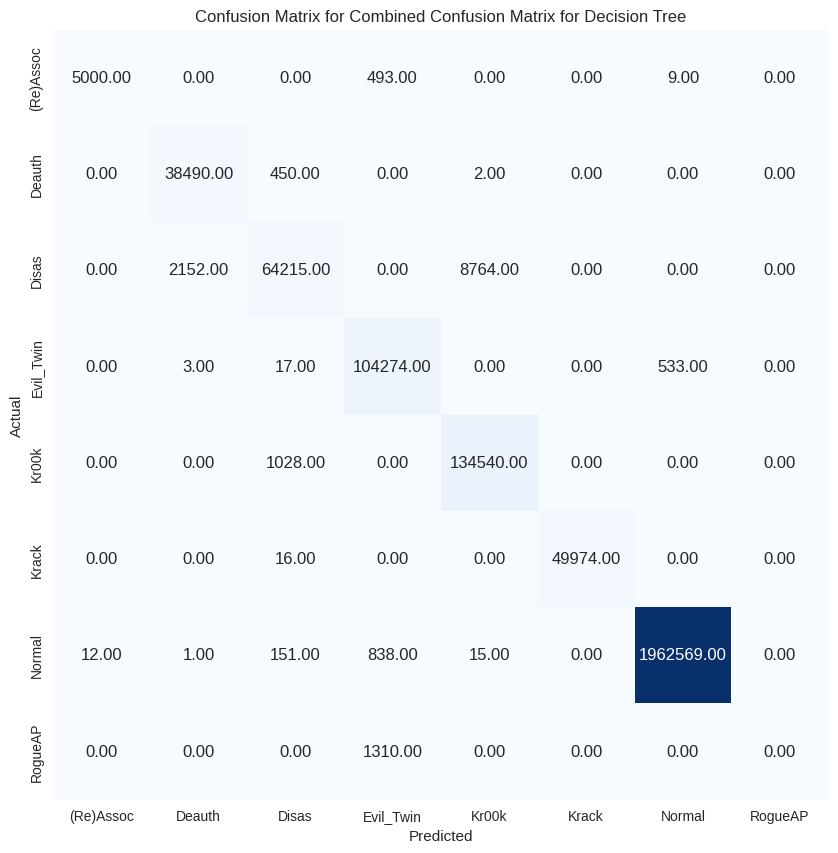

In [ ]:
results_list = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    results = train_and_eval_decision_tree(X_train, y_train, X_test, y_test)

    results_list.append(results)

print_average_results("Decision Tree", results_list)


Random Forest
Average Micro Precision: 0.9925439690451425
Average Micro Recall: 0.9925439690451425
Average Micro F1: 0.9925439690451425
Average Micro AUC: 0.9999341986694809

Average Macro Precision: 0.9803367629983665
Average Macro Recall: 0.8400907943861933
Average Macro F1: 0.8465862664315414
Average Macro AUC: 0.9996156316880247

Average Weighted Precision: 0.9927305684264107
Average Weighted Recall: 0.9925439690451425
Average Weighted F1: 0.9921532033397984
Average Weighted AUC: 0.9998870232895151

Average Accuracy: 0.9925439690451425


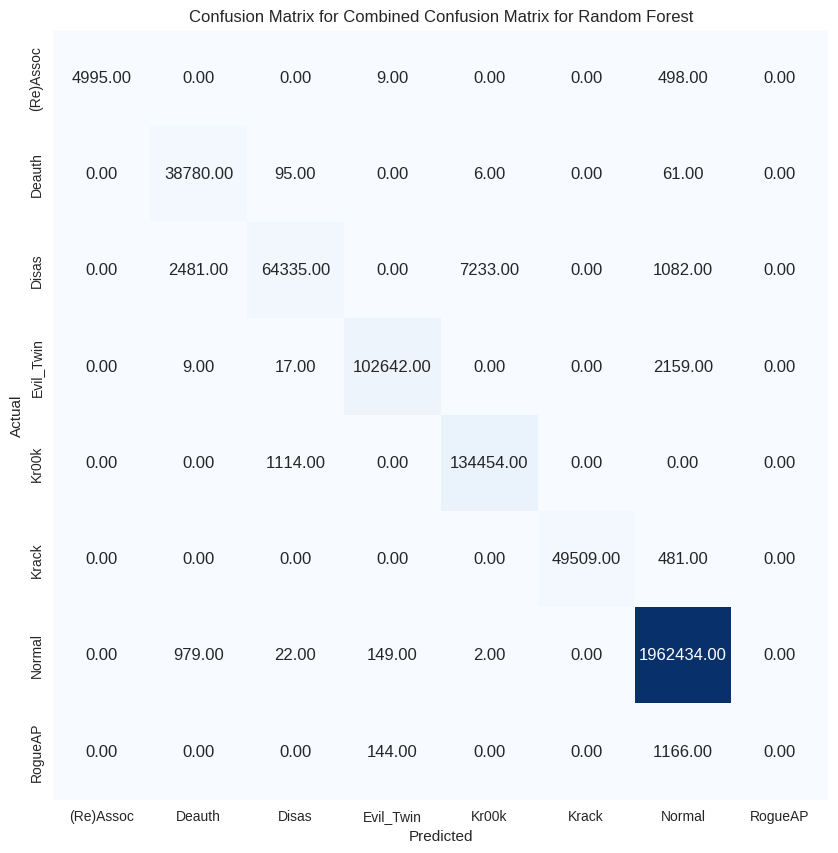

In [ ]:
results_list = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    results = train_and_eval_random_forest(X_train, y_train, X_test, y_test)

    results_list.append(results)

print_average_results("Random Forest", results_list)


Extra Trees
Average Micro Precision: 0.9909607155967409
Average Micro Recall: 0.9909607155967409
Average Micro F1: 0.9909607155967409
Average Micro AUC: 0.9999347774619908

Average Macro Precision: 0.9735199625738679
Average Macro Recall: 0.9661444968678665
Average Macro F1: 0.9665859711435454
Average Macro AUC: 0.9995429467746719

Average Weighted Precision: 0.9916300558058978
Average Weighted Recall: 0.9909607155967409
Average Weighted F1: 0.9903988418636782
Average Weighted AUC: 0.9998625901038057

Average Accuracy: 0.9909607155967409


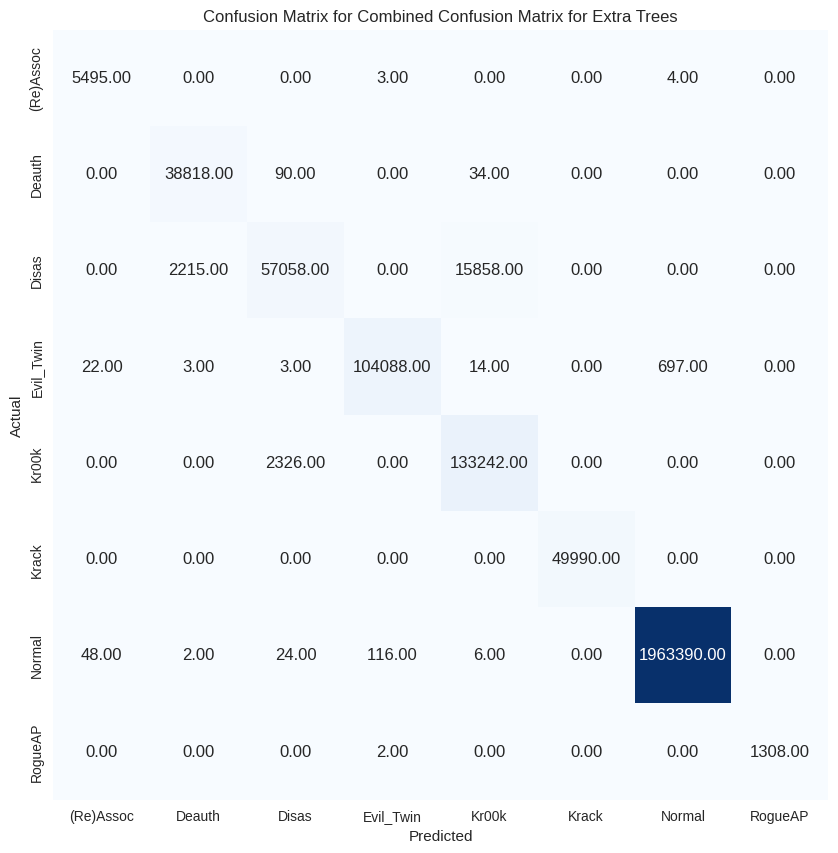

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Create an instance of StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_list = []
for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    results = train_and_eval_extra_trees(X_train, y_train, X_test, y_test)

    results_list.append(results)

print_average_results("Extra Trees", results_list)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Veri yükleme
df = pd.read_csv("/content/drive/MyDrive/AWID/CSV/12.Evil_Twin/Evil_Twin_0.csv")

# 2. Hedef değişken ile bağımsız değişkenleri ayır
X = df.drop("Label", axis=1)
y = df["Label"]

# 3. a) Tamamen boş veya sabit sütunları kaldır
def remove_constant_and_null_columns(df):
    nunique = df.nunique()
    null_ratio = df.isnull().mean()
    columns_to_drop = nunique[nunique <= 1].index.tolist() + null_ratio[null_ratio > 0.9].index.tolist()
    return df.drop(columns=columns_to_drop), columns_to_drop

X_cleaned, dropped_columns = remove_constant_and_null_columns(X)

print(f"Dropped {len(dropped_columns)} columns (null/sabit).")

# 3. b) Kategorik verileri sayısallaştır
X_encoded = pd.get_dummies(X_cleaned)

# 4. Düşük varyanslı sütunları çıkar (bilgi taşımayanlar)
selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X_encoded)
X_var_df = pd.DataFrame(X_var, columns=X_encoded.columns[selector.get_support()])

print(f"Selected {X_var_df.shape[1]} features after low-variance filtering.")

# 5. Yüksek korelasyonlu sütunlardan sadece birini bırak
def remove_highly_correlated_features(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(to_drop, axis=1), to_drop

X_corr_filtered, high_corr_dropped = remove_highly_correlated_features(X_var_df)

print(f"Removed {len(high_corr_dropped)} highly correlated features.")

# 6. Model tabanlı seçim (Random Forest ile en önemli 20 özelliği seç)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_corr_filtered, y)

importances = pd.Series(model.feature_importances_, index=X_corr_filtered.columns)
top_features = importances.sort_values(ascending=False).head(20).index

X_final = X_corr_filtered[top_features]

print("Selected Top 20 Features:")
print(top_features)

# (Opsiyonel) Özellik önemlerini görselleştir
importances[top_features].sort_values().plot(kind='barh', figsize=(10, 6), title='Özellik Önem Skoru')
plt.tight_layout()
plt.show()

<ipython-input-52-8ad813211357>:10: DtypeWarning: Columns (20,21,43,44,45,62,65,71,73,77,78,79,80,82,84,85,87,90,91,92,93,94,96,98,99,100,101,102,103,104,107,108,109,110,111,112,113,114,116,117,118,119,120,122,132,137,138,141,142,143,145,146,147,148,149,151,153,155,157,158,159,160,161,162,163,164,166,169,170,171,172,173,175,176,177,181,186,189,190,192,193,194,195,197,200,201,202,203,204,205,206,209,210,211,212,213,215,217,218,219,248,249) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/AWID3/12.Evil_Twin/Evil_Twin_0.csv")


Dropped 279 columns (null/sabit).


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Train/test böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# SMOTE uygula
smote = SMOTE(sampling_strategy="not majority", random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# DNN için float32 dönüşümü
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

from sklearn.model_selection import StratifiedKFold

k_folds = 10  # veya istersen 5
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

In [ ]:
def train_and_eval_dnn(X_train, y_train, X_test, y_test):
    # Label encoding
    label_encoder = LabelEncoder()
    y_train_enc = label_encoder.fit_transform(y_train['Label'])
    y_test_enc = label_encoder.transform(y_test['Label'])

    # One-hot encoding for Keras
    y_train_cat = to_categorical(y_train_enc)
    y_test_cat = to_categorical(y_test_enc)

    input_dim = X_train.shape[1]
    num_classes = y_train_cat.shape[1]

    # DNN modeli
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    # Eğitim
    history = model.fit(
        X_train,
        y_train_cat,
        validation_data=(X_test, y_test_cat),
        epochs=20,
        batch_size=256,
        verbose=1
    )

    # Tahmin ve değerlendirme
    y_pred_proba = model.predict(X_test)
    y_pred = y_pred_proba.argmax(axis=1)

    # evaluate_classifier formatına sokalım
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix
    from sklearn.preprocessing import label_binarize

    precision_micro = precision_score(y_test_enc, y_pred, average='micro', zero_division=1)
    recall_micro = recall_score(y_test_enc, y_pred, average='micro')
    f1_micro = f1_score(y_test_enc, y_pred, average='micro')
    auc_micro = roc_auc_score(label_binarize(y_test_enc, classes=range(num_classes)), y_pred_proba, average='micro', multi_class='ovr')

    precision_macro = precision_score(y_test_enc, y_pred, average='macro', zero_division=1)
    recall_macro = recall_score(y_test_enc, y_pred, average='macro')
    f1_macro = f1_score(y_test_enc, y_pred, average='macro')
    auc_macro = roc_auc_score(label_binarize(y_test_enc, classes=range(num_classes)), y_pred_proba, average='macro', multi_class='ovr')

    precision_weighted = precision_score(y_test_enc, y_pred, average='weighted', zero_division=1)
    recall_weighted = recall_score(y_test_enc, y_pred, average='weighted')
    f1_weighted = f1_score(y_test_enc, y_pred, average='weighted')
    auc_weighted = roc_auc_score(label_binarize(y_test_enc, classes=range(num_classes)), y_pred_proba, average='weighted', multi_class='ovr')

    accuracy = accuracy_score(y_test_enc, y_pred)
    cm = confusion_matrix(y_test_enc, y_pred)

    return [
        [precision_micro, recall_micro, f1_micro, auc_micro],
        [precision_macro, recall_macro, f1_macro, auc_macro],
        [precision_weighted, recall_weighted, f1_weighted, auc_weighted],
        accuracy,
        cm
    ]


In [ ]:
def print_average_results(name, results_list):
    classes = ["(Re)Assoc", "Deauth", "Disas", "Evil_Twin", "Kr00k", "Krack", "Normal", "RogueAP"]
    print(f"\n{name}")

    average_precision_micro = sum(result[0][0] for result in results_list) / len(results_list)
    average_recall_micro = sum(result[0][1] for result in results_list) / len(results_list)
    average_f1_micro = sum(result[0][2] for result in results_list) / len(results_list)
    average_auc_micro = sum(result[0][3] for result in results_list) / len(results_list)

    average_precision_macro = sum(result[1][0] for result in results_list) / len(results_list)
    average_recall_macro = sum(result[1][1] for result in results_list) / len(results_list)
    average_f1_macro = sum(result[1][2] for result in results_list) / len(results_list)
    average_auc_macro = sum(result[1][3] for result in results_list) / len(results_list)

    average_precision_weighted = sum(result[2][0] for result in results_list) / len(results_list)
    average_recall_weighted = sum(result[2][1] for result in results_list) / len(results_list)
    average_f1_weighted = sum(result[2][2] for result in results_list) / len(results_list)
    average_auc_weighted = sum(result[2][3] for result in results_list) / len(results_list)

    average_accuracy = sum(result[3] for result in results_list) / len(results_list)

    # Confusion matrixleri topla
    combined_cm = None
    for result in results_list:
        if combined_cm is None:
            combined_cm = result[4]
        else:
            combined_cm += result[4]

    # Yazdır
    print("Average Micro Precision:", average_precision_micro)
    print("Average Micro Recall:", average_recall_micro)
    print("Average Micro F1:", average_f1_micro)
    print("Average Micro AUC:", average_auc_micro)

    print("\nAverage Macro Precision:", average_precision_macro)
    print("Average Macro Recall:", average_recall_macro)
    print("Average Macro F1:", average_f1_macro)
    print("Average Macro AUC:", average_auc_macro)

    print("\nAverage Weighted Precision:", average_precision_weighted)
    print("Average Weighted Recall:", average_recall_weighted)
    print("Average Weighted F1:", average_f1_weighted)
    print("Average Weighted AUC:", average_auc_weighted)

    print("\nAverage Accuracy:", average_accuracy)

    # Confusion Matrix görseli
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 10))
    sns.heatmap(combined_cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Combined Confusion Matrix for {name}')
    plt.show()


Fold 1 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9660 - loss: 0.0824 - val_accuracy: 0.9770 - val_loss: 0.0506
Epoch 2/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9761 - loss: 0.0556 - val_accuracy: 0.9873 - val_loss: 0.0594
Epoch 3/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9791 - loss: 0.0510 - val_accuracy: 0.9776 - val_loss: 0.0493
Epoch 4/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9774 - loss: 0.0536 - val_accuracy: 0.9862 - val_loss: 0.0444
Epoch 5/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9793 - loss: 0.0499 - val_accuracy: 0.9859 - val_loss: 0.0349
Epoch 6/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9813 - loss: 0.0467 - val_accuracy: 0.9894 - val_loss: 0.0299
Epoch 7/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9846 - loss: 0.0401 - val_accuracy: 0.9858 - val_loss: 0.0334
Epoch 8/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9863 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9668 - loss: 0.0807 - val_accuracy: 0.9759 - val_loss: 0.0527
Epoch 2/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9752 - loss: 0.0561 - val_accuracy: 0.9417 - val_loss: 0.0911
Epoch 3/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9768 - loss: 0.0542 - val_accuracy: 0.9748 - val_loss: 0.0521
Epoch 4/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9748 - loss: 0.0572 - val_accuracy: 0.9814 - val_loss: 0.0416
Epoch 5/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9796 - loss: 0.0496 - val_accuracy: 0.9892 - val_loss: 0.0414
Epoch 6/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9826 - loss: 0.0438 - val_accuracy: 0.9840 - val_loss: 0.0397
Epoch 7/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9820 - loss: 0.0450 - val_accuracy: 0.9906 - val_loss: 0.0258
Epoch 8/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9852 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9666 - loss: 0.0812 - val_accuracy: 0.9760 - val_loss: 0.0521
Epoch 2/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9767 - loss: 0.0546 - val_accuracy: 0.9859 - val_loss: 0.0652
Epoch 3/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9777 - loss: 0.0529 - val_accuracy: 0.9847 - val_loss: 0.0459
Epoch 4/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9782 - loss: 0.0521 - val_accuracy: 0.9836 - val_loss: 0.0434
Epoch 5/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9793 - loss: 0.0501 - val_accuracy: 0.9867 - val_loss: 0.0380
Epoch 6/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9816 - loss: 0.0460 - val_accuracy: 0.9836 - val_loss: 0.0409
Epoch 7/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9823 - loss: 0.0450 - val_accuracy: 0.9780 - val_loss: 0.0389
Epoch 8/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9865 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9653 - loss: 0.0846 - val_accuracy: 0.9740 - val_loss: 0.0566
Epoch 2/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9752 - loss: 0.0568 - val_accuracy: 0.9781 - val_loss: 0.0501
Epoch 3/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9795 - loss: 0.0498 - val_accuracy: 0.9883 - val_loss: 0.0341
Epoch 4/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9763 - loss: 0.0548 - val_accuracy: 0.9826 - val_loss: 0.0493
Epoch 5/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9776 - loss: 0.0527 - val_accuracy: 0.9777 - val_loss: 0.0458
Epoch 6/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9775 - loss: 0.0529 - val_accuracy: 0.9769 - val_loss: 0.0500
Epoch 7/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9811 - loss: 0.0472 - val_accuracy: 0.9405 - val_loss: 0.0654
Epoch 8/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9821 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9628 - loss: 0.0951 - val_accuracy: 0.9735 - val_loss: 0.0553
Epoch 2/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9747 - loss: 0.0576 - val_accuracy: 0.9902 - val_loss: 0.0504
Epoch 3/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9797 - loss: 0.0497 - val_accuracy: 0.9867 - val_loss: 0.0464
Epoch 4/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9793 - loss: 0.0497 - val_accuracy: 0.9904 - val_loss: 0.0527
Epoch 5/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9830 - loss: 0.0437 - val_accuracy: 0.9891 - val_loss: 0.0424
Epoch 6/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9827 - loss: 0.0425 - val_accuracy: 0.9882 - val_loss: 0.0437
Epoch 7/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9806 - loss: 0.0472 - val_accuracy: 0.9915 - val_loss: 0.0284
Epoch 8/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9859 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9665 - loss: 0.0809 - val_accuracy: 0.9819 - val_loss: 0.0600
Epoch 2/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9757 - loss: 0.0559 - val_accuracy: 0.9720 - val_loss: 0.0538
Epoch 3/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9770 - loss: 0.0533 - val_accuracy: 0.9825 - val_loss: 0.0535
Epoch 4/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9760 - loss: 0.0550 - val_accuracy: 0.9774 - val_loss: 0.0457
Epoch 5/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9777 - loss: 0.0525 - val_accuracy: 0.9761 - val_loss: 0.0530
Epoch 6/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9796 - loss: 0.0494 - val_accuracy: 0.9822 - val_loss: 0.0443
Epoch 7/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9808 - loss: 0.0475 - val_accuracy: 0.9904 - val_loss: 0.0431
Epoch 8/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9813 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9673 - loss: 0.0796 - val_accuracy: 0.9760 - val_loss: 0.0506
Epoch 2/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9760 - loss: 0.0558 - val_accuracy: 0.9834 - val_loss: 0.0370
Epoch 3/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9800 - loss: 0.0488 - val_accuracy: 0.9744 - val_loss: 0.0480
Epoch 4/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9774 - loss: 0.0530 - val_accuracy: 0.9804 - val_loss: 0.0436
Epoch 5/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9829 - loss: 0.0432 - val_accuracy: 0.9828 - val_loss: 0.0454
Epoch 6/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9835 - loss: 0.0414 - val_accuracy: 0.9883 - val_loss: 0.0358
Epoch 7/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9814 - loss: 0.0449 - val_accuracy: 0.9844 - val_loss: 0.0362
Epoch 8/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9816 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9651 - loss: 0.0848 - val_accuracy: 0.9772 - val_loss: 0.0587
Epoch 2/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9748 - loss: 0.0573 - val_accuracy: 0.9778 - val_loss: 0.0528
Epoch 3/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9761 - loss: 0.0551 - val_accuracy: 0.9790 - val_loss: 0.0451
Epoch 4/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9778 - loss: 0.0527 - val_accuracy: 0.9890 - val_loss: 0.0489
Epoch 5/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9797 - loss: 0.0494 - val_accuracy: 0.9844 - val_loss: 0.0402
Epoch 6/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9812 - loss: 0.0471 - val_accuracy: 0.9854 - val_loss: 0.0383
Epoch 7/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9824 - loss: 0.0446 - val_accuracy: 0.9889 - val_loss: 0.0362
Epoch 8/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9824 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9665 - loss: 0.0811 - val_accuracy: 0.9743 - val_loss: 0.0519
Epoch 2/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9759 - loss: 0.0557 - val_accuracy: 0.9772 - val_loss: 0.0524
Epoch 3/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9765 - loss: 0.0546 - val_accuracy: 0.9806 - val_loss: 0.0559
Epoch 4/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9757 - loss: 0.0559 - val_accuracy: 0.9860 - val_loss: 0.0474
Epoch 5/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9797 - loss: 0.0500 - val_accuracy: 0.9864 - val_loss: 0.0300
Epoch 6/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9853 - loss: 0.0388 - val_accuracy: 0.9917 - val_loss: 0.0248
Epoch 7/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9837 - loss: 0.0410 - val_accuracy: 0.9907 - val_loss: 0.0273
Epoch 8/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9858 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9673 - loss: 0.0803 - val_accuracy: 0.9787 - val_loss: 0.0614
Epoch 2/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9750 - loss: 0.0570 - val_accuracy: 0.9399 - val_loss: 0.0716
Epoch 3/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9775 - loss: 0.0531 - val_accuracy: 0.9902 - val_loss: 0.0364
Epoch 4/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9803 - loss: 0.0478 - val_accuracy: 0.9801 - val_loss: 0.0450
Epoch 5/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9800 - loss: 0.0480 - val_accuracy: 0.9771 - val_loss: 0.0466
Epoch 6/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9783 - loss: 0.0517 - val_accuracy: 0.9862 - val_loss: 0.0364
Epoch 7/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9827 - loss: 0.0439 - val_accuracy: 0.9886 - val_loss: 0.0334
Epoch 8/20
8350/8350 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9839 - loss: 0

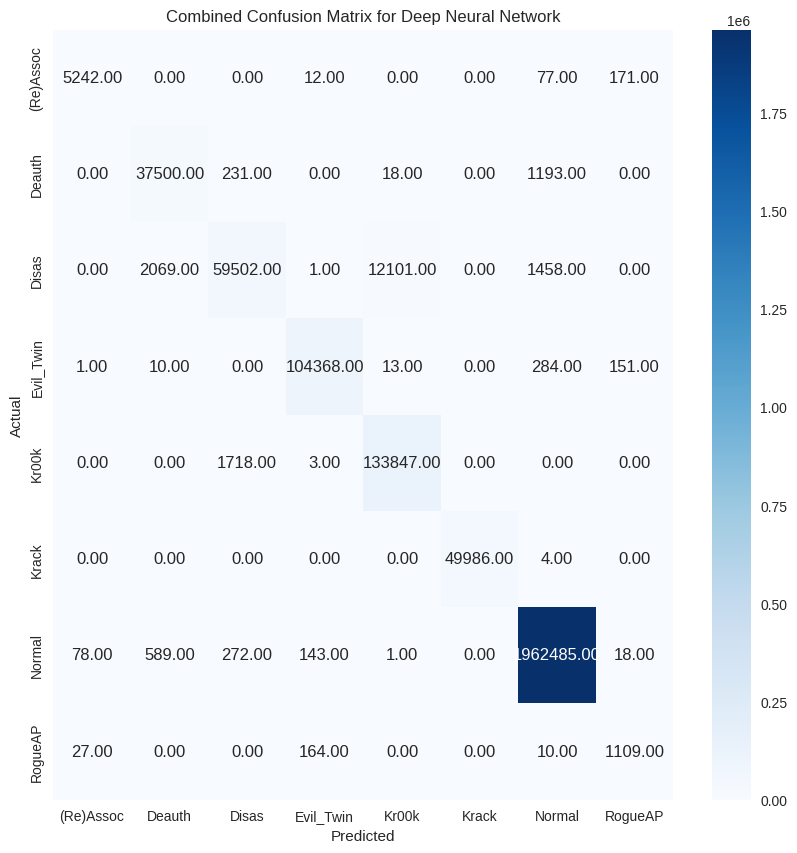

In [ ]:
results_list = []

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    print(f"Fold {fold+1} başlatılıyor...")

    # X, y DataFrame ise .iloc kullanılmalı
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    results = train_and_eval_dnn(X_train, y_train, X_test, y_test)
    results_list.append(results)

print_average_results("Deep Neural Network", results_list)


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier

results_list = []

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    print(f"Fold {fold + 1} başlatılıyor...")

    # Veriyi ayır
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Encode et
    y_train_enc = y_train['Label'].astype('category').cat.codes
    y_test_enc = y_test['Label'].astype('category').cat.codes
    class_names = y_test['Label'].astype('category').cat.categories

    # Modeli eğit
    model = ExtraTreesClassifier(
        max_depth=200,
        n_estimators=200,
        ccp_alpha=0.0001,
        max_leaf_nodes=500,
        min_samples_leaf=2,
        min_samples_split=10,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train_enc)
    y_pred = model.predict(X_test)

    # Sınıf bazlı metrikleri hesapla
    report = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_classes = df_report.iloc[:-3][['precision', 'recall', 'f1-score']]
    df_classes['fold'] = fold + 1

    results_list.append(df_classes)

# Tüm fold'ları birleştir
df_all = pd.concat(results_list)

# Ortalama metrikleri hesapla
df_avg = df_all.groupby(df_all.index)[['precision', 'recall', 'f1-score']].mean()

# Sonucu yazdır
from IPython.display import display
print("📌 Extra Trees - Sınıf Bazlı Ortalama Metrikler (10 Fold):")
display(df_avg)


Fold 1 başlatılıyor...
Fold 2 başlatılıyor...
Fold 3 başlatılıyor...
Fold 4 başlatılıyor...
Fold 5 başlatılıyor...
Fold 6 başlatılıyor...
Fold 7 başlatılıyor...
Fold 8 başlatılıyor...
Fold 9 başlatılıyor...
Fold 10 başlatılıyor...
📌 Extra Trees - Sınıf Bazlı Ortalama Metrikler (10 Fold):


,precision,recall,f1-score
(Re)Assoc,0.987463,0.999091,0.993232
Deauth,0.945918,0.996816,0.970696
Disas,0.955816,0.739271,0.822975
Evil_Twin,0.998887,0.992950,0.995910
Kr00k,0.890681,0.982887,0.932877
Krack,1.000000,1.000000,1.000000
Normal,0.999643,0.999901,0.999772
RogueAP,1.000000,0.999237,0.999617


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd

results_list = []

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    print(f"Fold {fold + 1} başlatılıyor...")

    # Veriyi ayır
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Label encoding
    y_train_enc = y_train['Label'].astype('category').cat.codes
    y_test_enc = y_test['Label'].astype('category').cat.codes
    class_names = y_test['Label'].astype('category').cat.categories

    # Logistic Regression modeli
    model = LogisticRegression(
        solver='sag',
        max_iter=500,
        tol=0.01,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train_enc)
    y_pred = model.predict(X_test)

    # Sınıf bazlı metrikleri hesapla
    report = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    # Accuracy satırı özel olduğu için ayrı alınır
    accuracy = df_report.loc['accuracy', 'precision']

    # Sınıf bazlı metrikleri al
    df_classes = df_report.iloc[:-3][['precision', 'recall', 'f1-score']]
    df_classes['fold'] = fold + 1
    df_classes['accuracy'] = accuracy  # Accuracy her sınıfa aynı şekilde eklenmiş olur

    results_list.append(df_classes)

# Tüm fold sonuçlarını birleştir
df_all = pd.concat(results_list)

# Sınıf bazlı ortalamaları al
df_avg = df_all.groupby(df_all.index)[['precision', 'recall', 'f1-score']].mean()

# Accuracy ortalaması
accuracy_avg = df_all['accuracy'].mean()

# Göster
from IPython.display import display
print("📌 Logistic Regression - Sınıf Bazlı Ortalama Metrikler (10 Fold):")
display(df_avg)

print("\n✅ Logistic Regression - Ortalama Accuracy:", round(accuracy_avg, 4))

Fold 1 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 6 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 7 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 8 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 9 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 10 başlatılıyor...
📌 Logistic Regression - Sınıf Bazlı Ortalama Metrikler (10 Fold):


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score
(Re)Assoc,0.990169,0.909852,0.948256
Deauth,0.785359,0.994659,0.877677
Disas,0.757390,0.395443,0.519566
Evil_Twin,0.987658,0.995564,0.991588
Kr00k,0.757002,0.935413,0.836800
Krack,0.999980,1.000000,0.999990
Normal,0.998482,0.995676,0.997077
RogueAP,0.000000,0.000000,0.000000



✅ Logistic Regression - Ortalama Accuracy: 0.9726


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
import pandas as pd

results_list = []

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    print(f"Fold {fold + 1} başlatılıyor...")

    # Veriyi ayır
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Label encoding
    y_train_enc = y_train['Label'].astype('category').cat.codes
    y_test_enc = y_test['Label'].astype('category').cat.codes
    class_names = y_test['Label'].astype('category').cat.categories

    # SGDClassifier modeli
    model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42)
    model.fit(X_train, y_train_enc)
    y_pred = model.predict(X_test)

    # Sınıf bazlı metrikleri hesapla
    report = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    # Accuracy satırı özel olduğu için ayrı alınır
    accuracy = df_report.loc['accuracy', 'precision']

    # Sınıf bazlı metrikleri al
    df_classes = df_report.iloc[:-3][['precision', 'recall', 'f1-score']]
    df_classes['fold'] = fold + 1
    df_classes['accuracy'] = accuracy

    results_list.append(df_classes)

# Tüm fold sonuçlarını birleştir
df_all = pd.concat(results_list)

# Sınıf bazlı ortalamaları al
df_avg = df_all.groupby(df_all.index)[['precision', 'recall', 'f1-score']].mean()

# Accuracy ortalaması
accuracy_avg = df_all['accuracy'].mean()

# Göster
from IPython.display import display
print("📌 SGDClassifier - Sınıf Bazlı Ortalama Metrikler (10 Fold):")
display(df_avg)

print("\n✅ SGDClassifier - Ortalama Accuracy:", round(accuracy_avg, 4))


Fold 1 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 6 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 7 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 8 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 9 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 10 başlatılıyor...
📌 SGDClassifier - Sınıf Bazlı Ortalama Metrikler (10 Fold):


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score
(Re)Assoc,0.977068,0.910397,0.942494
Deauth,0.728975,0.998742,0.842770
Disas,0.949745,0.317352,0.474852
Evil_Twin,0.994078,0.960716,0.977111
Kr00k,0.748085,0.990263,0.852263
Krack,1.000000,0.999960,0.999980
Normal,0.997005,0.995388,0.996195
RogueAP,0.000000,0.000000,0.000000



✅ SGDClassifier - Ortalama Accuracy: 0.9715


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import pandas as pd

results_list = []

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    print(f"Fold {fold + 1} başlatılıyor...")

    # Veriyi ayır
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Label encoding
    y_train_enc = y_train['Label'].astype('category').cat.codes
    y_test_enc = y_test['Label'].astype('category').cat.codes
    class_names = y_test['Label'].astype('category').cat.categories

    # LinearSVC modeli
    model = LinearSVC(max_iter=2000, dual=False)
    model.fit(X_train, y_train_enc)
    y_pred = model.predict(X_test)

    # Sınıf bazlı metrikleri hesapla
    report = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    # Accuracy özel satırdır
    accuracy = df_report.loc['accuracy', 'precision']

    # Sınıf metrikleri
    df_classes = df_report.iloc[:-3][['precision', 'recall', 'f1-score']]
    df_classes['fold'] = fold + 1
    df_classes['accuracy'] = accuracy

    results_list.append(df_classes)

# Tüm fold sonuçlarını birleştir
df_all = pd.concat(results_list)

# Sınıf bazlı ortalamalar
df_avg = df_all.groupby(df_all.index)[['precision', 'recall', 'f1-score']].mean()

# Accuracy ortalaması
accuracy_avg = df_all['accuracy'].mean()

# Göster
from IPython.display import display
print("📌 LinearSVC - Sınıf Bazlı Ortalama Metrikler (10 Fold):")
display(df_avg)

print("\n✅ LinearSVC - Ortalama Accuracy:", round(accuracy_avg, 4))


Fold 1 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 6 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 7 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 8 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 9 başlatılıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 10 başlatılıyor...
📌 LinearSVC - Sınıf Bazlı Ortalama Metrikler (10 Fold):


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score
(Re)Assoc,0.988820,0.910397,0.947932
Deauth,0.773393,0.997509,0.871247
Disas,0.763470,0.374546,0.502538
Evil_Twin,0.986083,0.995583,0.990810
Kr00k,0.756113,0.935811,0.836417
Krack,0.999940,0.999980,0.999960
Normal,0.998147,0.995858,0.997001
RogueAP,0.000000,0.000000,0.000000



✅ LinearSVC - Ortalama Accuracy: 0.9721


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
import pandas as pd

results_list = []

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    print(f"Fold {fold + 1} başlatılıyor...")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Label encoding
    y_train_enc = y_train['Label'].astype('category').cat.codes
    y_test_enc = y_test['Label'].astype('category').cat.codes
    class_names = y_test['Label'].astype('category').cat.categories

    # LightGBM model
    model = LGBMClassifier(
        objective='multiclass',
        num_class=len(class_names),
        metric='multi_logloss',
        boosting_type='gbdt',
        num_leaves=20,
        learning_rate=0.01,
        max_depth=10,
        n_estimators=80,
        reg_alpha=0.01,
        reg_lambda=0.01,
        n_jobs=-1,
        verbose=-1
    )

    model.fit(X_train, y_train_enc)
    y_pred = model.predict(X_test)

    # Tüm sınıf metriklerini al
    report = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    # Fold ve accuracy bilgisi ekle
    df_report['fold'] = fold + 1
    df_report['accuracy'] = df_report.loc['accuracy', 'precision']

    # Sadece sınıf isimli satırları al
    df_classes = df_report.loc[class_names]
    results_list.append(df_classes)

# Tüm fold sonuçlarını birleştir
df_all = pd.concat(results_list)

# Ortalamaları al
df_avg = df_all.groupby(df_all.index)[['precision', 'recall', 'f1-score', 'support']].mean()
accuracy_avg = df_all['accuracy'].mean()

# Göster
from IPython.display import display
print("📌 LightGBM - Her Sınıf İçin Ortalama Metrikler (10 Fold):")
display(df_avg)

print("\n✅ Ortalama Accuracy:", round(accuracy_avg, 4))

Fold 1 başlatılıyor...
Fold 2 başlatılıyor...
Fold 3 başlatılıyor...
Fold 4 başlatılıyor...
Fold 5 başlatılıyor...
Fold 6 başlatılıyor...
Fold 7 başlatılıyor...
Fold 8 başlatılıyor...
Fold 9 başlatılıyor...
Fold 10 başlatılıyor...
📌 LightGBM - Her Sınıf İçin Ortalama Metrikler (10 Fold):


,precision,recall,f1-score,support
(Re)Assoc,1.000000,0.998364,0.999181,550.2
Deauth,0.950481,0.994325,0.971904,3894.2
Disas,0.959240,0.925863,0.942248,7513.1
Evil_Twin,0.999521,0.995593,0.997553,10482.7
Kr00k,0.975115,0.979715,0.977408,13556.8
Krack,1.000000,1.000000,1.000000,4999.0
Normal,0.999654,0.999958,0.999806,196358.6
RogueAP,1.000000,1.000000,1.000000,131.0



✅ Ortalama Accuracy: 0.9962


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import pandas as pd

results_list = []

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    print(f"Fold {fold + 1} başlatılıyor...")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Label encoding
    y_train_enc = y_train['Label'].astype('category').cat.codes
    y_test_enc = y_test['Label'].astype('category').cat.codes
    class_names = y_test['Label'].astype('category').cat.categories

    # Model
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train_enc)
    y_pred = model.predict(X_test)

    # Sınıf bazlı metrikleri al
    report = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    # Fold ve accuracy bilgisi ekle
    df_report['fold'] = fold + 1
    df_report['accuracy'] = df_report.loc['accuracy', 'precision']

    # Sadece sınıf isimli satırları al
    df_classes = df_report.loc[class_names]
    results_list.append(df_classes)

# Tüm fold sonuçlarını birleştir
df_all = pd.concat(results_list)

# Ortalamaları al
df_avg = df_all.groupby(df_all.index)[['precision', 'recall', 'f1-score', 'support']].mean()
accuracy_avg = df_all['accuracy'].mean()

# Göster
from IPython.display import display
print("📌 Decision Tree - Her Sınıf İçin Ortalama Metrikler (10 Fold):")
display(df_avg)

print("\n✅ Ortalama Accuracy:", round(accuracy_avg, 4))


Fold 1 başlatılıyor...
Fold 2 başlatılıyor...
Fold 3 başlatılıyor...
Fold 4 başlatılıyor...
Fold 5 başlatılıyor...
Fold 6 başlatılıyor...
Fold 7 başlatılıyor...
Fold 8 başlatılıyor...
Fold 9 başlatılıyor...
Fold 10 başlatılıyor...
📌 Decision Tree - Her Sınıf İçin Ortalama Metrikler (10 Fold):


,precision,recall,f1-score,support
(Re)Assoc,0.999456,0.999273,0.999364,550.2
Deauth,0.950900,0.993760,0.971852,3894.2
Disas,0.962272,0.925703,0.943631,7513.1
Evil_Twin,0.998008,0.998741,0.998374,10482.7
Kr00k,0.973718,0.981891,0.977787,13556.8
Krack,1.000000,0.999980,0.999990,4999.0
Normal,0.999933,0.999874,0.999903,196358.6
RogueAP,0.999242,1.000000,0.999620,131.0



✅ Ortalama Accuracy: 0.9964


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
import pandas as pd

results_list = []

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    print(f"Fold {fold + 1} başlatılıyor...")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Label encoding
    y_train_enc = y_train['Label'].astype('category').cat.codes
    y_test_enc = y_test['Label'].astype('category').cat.codes
    class_names = y_test['Label'].astype('category').cat.categories

    # Model
    model = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train_enc)
    y_pred = model.predict(X_test)

    # Metrikler
    report = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    df_report['fold'] = fold + 1
    df_report['accuracy'] = df_report.loc['accuracy', 'precision']

    df_classes = df_report.loc[class_names]
    results_list.append(df_classes)

# Tüm fold sonuçlarını birleştir
df_all = pd.concat(results_list)

# Ortalamaları al
df_avg = df_all.groupby(df_all.index)[['precision', 'recall', 'f1-score', 'support']].mean()
accuracy_avg = df_all['accuracy'].mean()

# Göster
from IPython.display import display
print("📌 Extra Trees - Her Sınıf İçin Ortalama Metrikler (10 Fold):")
display(df_avg)

print("\n✅ Ortalama Accuracy:", round(accuracy_avg, 4))


Fold 1 başlatılıyor...
Fold 2 başlatılıyor...
Fold 3 başlatılıyor...
Fold 4 başlatılıyor...
Fold 5 başlatılıyor...
Fold 6 başlatılıyor...
Fold 7 başlatılıyor...
Fold 8 başlatılıyor...
Fold 9 başlatılıyor...
Fold 10 başlatılıyor...
📌 Extra Trees - Her Sınıf İçin Ortalama Metrikler (10 Fold):


,precision,recall,f1-score,support
(Re)Assoc,0.999456,0.999273,0.999364,550.2
Deauth,0.950922,0.993734,0.971851,3894.2
Disas,0.962299,0.925703,0.943643,7513.1
Evil_Twin,0.998075,0.998741,0.998407,10482.7
Kr00k,0.973718,0.981891,0.977787,13556.8
Krack,1.000000,1.000000,1.000000,4999.0
Normal,0.999933,0.999880,0.999906,196358.6
RogueAP,1.000000,1.000000,1.000000,131.0



✅ Ortalama Accuracy: 0.9964


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd

results_list = []

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    print(f"Fold {fold + 1} başlatılıyor...")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Label encoding
    y_train_enc = y_train['Label'].astype('category').cat.codes
    y_test_enc = y_test['Label'].astype('category').cat.codes
    class_names = y_test['Label'].astype('category').cat.categories

    # Random Forest Modeli
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train_enc)
    y_pred = model.predict(X_test)

    # Rapor
    report = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    df_report['fold'] = fold + 1
    df_report['accuracy'] = df_report.loc['accuracy', 'precision']

    # Sadece sınıf isimlerine ait veriyi al
    df_classes = df_report.loc[class_names]
    results_list.append(df_classes)

# Sonuçları birleştir
df_all = pd.concat(results_list)

# Sınıf bazlı ortalamalar
df_avg = df_all.groupby(df_all.index)[['precision', 'recall', 'f1-score', 'support']].mean()
accuracy_avg = df_all['accuracy'].mean()

# Gösterim
from IPython.display import display
print("📌 Random Forest - Her Sınıf İçin Ortalama Metrikler (10 Fold):")
display(df_avg)

print("\n✅ Ortalama Accuracy:", round(accuracy_avg, 4))


Fold 1 başlatılıyor...
Fold 2 başlatılıyor...
Fold 3 başlatılıyor...
Fold 4 başlatılıyor...
Fold 5 başlatılıyor...
Fold 6 başlatılıyor...
Fold 7 başlatılıyor...
Fold 8 başlatılıyor...
Fold 9 başlatılıyor...
Fold 10 başlatılıyor...
📌 Random Forest - Her Sınıf İçin Ortalama Metrikler (10 Fold):


,precision,recall,f1-score,support
(Re)Assoc,0.999456,0.999273,0.999364,550.2
Deauth,0.951466,0.992938,0.971755,3894.2
Disas,0.961979,0.926023,0.943656,7513.1
Evil_Twin,0.998226,0.998560,0.998393,10482.7
Kr00k,0.973712,0.981935,0.977806,13556.8
Krack,1.000000,1.000000,1.000000,4999.0
Normal,0.999924,0.999888,0.999906,196358.6
RogueAP,0.999242,1.000000,0.999620,131.0



✅ Ortalama Accuracy: 0.9964


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

results_list = []
accuracy_list = []

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    print(f"Fold {fold + 1} başlatılıyor...")

    # Veriyi ayır
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Label encoding
    label_encoder = LabelEncoder()
    y_train_enc = label_encoder.fit_transform(y_train['Label'])
    y_test_enc = label_encoder.transform(y_test['Label'])
    class_names = label_encoder.classes_

    # One-hot encode
    y_train_cat = to_categorical(y_train_enc)
    y_test_cat = to_categorical(y_test_enc)

    # Model
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(len(class_names), activation='softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    # Eğitim
    model.fit(
        X_train,
        y_train_cat,
        validation_data=(X_test, y_test_cat),
        epochs=20,
        batch_size=256,
        verbose=0
    )

    # Tahmin
    y_pred_proba = model.predict(X_test)
    y_pred = y_pred_proba.argmax(axis=1)

    # Rapor
    report = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    df_report['fold'] = fold + 1
    df_report['accuracy'] = accuracy_score(y_test_enc, y_pred)

    # Sınıf metrikleri
    df_classes = df_report.loc[class_names]
    results_list.append(df_classes)
    accuracy_list.append(df_report.loc['accuracy', 'accuracy'])

# Birleştir
df_all = pd.concat(results_list)

# Ortalama metrikler
df_avg = df_all.groupby(df_all.index)[['precision', 'recall', 'f1-score', 'support']].mean()
accuracy_avg = sum(accuracy_list) / len(accuracy_list)

# Göster
from IPython.display import display
print("📌 DNN - Her Sınıf İçin Ortalama Metrikler (10 Fold):")
display(df_avg)

print("\n✅ Ortalama Accuracy:", round(accuracy_avg, 4))


Fold 1 başlatılıyor...
7422/7422 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Fold 2 başlatılıyor...
7422/7422 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Fold 3 başlatılıyor...
7422/7422 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Fold 4 başlatılıyor...
7422/7422 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Fold 5 başlatılıyor...
7422/7422 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Fold 6 başlatılıyor...
7422/7422 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Fold 7 başlatılıyor...
7422/7422 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Fold 8 başlatılıyor...
7422/7422 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Fold 9 başlatılıyor...
7422/7422 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Fold 10 başlatılıyor...
7422/7422 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
📌 DNN - Her Sınıf İçin Ortalama Metrikler (10 Fold):


,precision,recall,f1-score,support
(Re)Assoc,0.979379,0.947836,0.963176,550.2
Deauth,0.947109,0.924273,0.935125,3894.2
Disas,0.963583,0.695850,0.802286,7513.1
Evil_Twin,0.997839,0.994467,0.996149,10482.7
Kr00k,0.875135,0.992432,0.929290,13556.8
Krack,1.000000,0.999920,0.999960,4999.0
Normal,0.997848,0.999609,0.998728,196358.6
RogueAP,0.754538,0.903053,0.820811,131.0



✅ Ortalama Accuracy: 0.988


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

# CNN için sonuç listesi
results_list = []

# Fold ayarı (10 olmalı diğer modellerle karşılaştırma için)
k_folds = 10
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    print(f"Fold {fold+1} başlatılıyor...")

    # Veriyi ayır
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Label encode
    label_encoder = LabelEncoder()
    y_train_enc = label_encoder.fit_transform(y_train['Label'])
    y_test_enc = label_encoder.transform(y_test['Label'])
    class_names = label_encoder.classes_

    # One-hot encode
    y_train_cat = to_categorical(y_train_enc)
    y_test_cat = to_categorical(y_test_enc)

    # CNN input şekli (num_samples, num_features, 1)
    X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)).astype(np.float32)
    X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1)).astype(np.float32)

    # CNN modeli
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_cnn, y_train_cat, validation_data=(X_test_cnn, y_test_cat), epochs=20, batch_size=256, verbose=0)

    # Tahminler
    y_pred = model.predict(X_test_cnn).argmax(axis=1)

    # Sınıf bazlı metrikleri hesapla
    report = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_classes = df_report.iloc[:-3][['precision', 'recall', 'f1-score']]
    df_classes['fold'] = fold + 1

    results_list.append(df_classes)

# Tüm fold'ları birleştir
df_all = pd.concat(results_list)

# Sınıf bazlı ortalamalar
df_avg = df_all.groupby(df_all.index)[['precision', 'recall', 'f1-score']].mean()

# Göster
from IPython.display import display
print("📌 CNN - Sınıf Bazlı Ortalama Metrikler (10 Fold):")
display(df_avg)


In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# 1. Veriyi train ve final test olarak ayır (stratify unutma)
X_full_train, X_final_test, y_full_train, y_final_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=42
)

# 2. 10-fold stratified KFold
k_folds = 10
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# 3. Modeli her fold için eğit ve sakla
lr_models = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X_full_train, y_full_train)):
    print(f"Fold {fold+1} eğitiliyor...")
    X_train_fold = X_full_train.iloc[train_idx]
    y_train_fold = y_full_train.iloc[train_idx]

    # Label encode
    y_train_enc = y_train_fold['Label'].astype('category').cat.codes

    # Model
    model = LogisticRegression(
        solver='sag',
        max_iter=500,
        tol=0.01,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_fold, y_train_enc)
    lr_models.append(model)

# 4. Final test seti ile tahmin
# Label encode (önce tüm sınıf isimlerini al)
label_encoder = y['Label'].astype('category').cat.categories
y_test_enc = y_final_test['Label'].astype('category').cat.codes

# Her modelin tahminini al
preds = []
for model in lr_models:
    pred = model.predict(X_final_test)
    preds.append(pred)

# Çoğunluk oyu (mode değil, ortalama alıp yuvarlıyoruz)
final_preds = np.round(np.mean(preds, axis=0)).astype(int)

# 5. Raporla
report = classification_report(
    y_test_enc,
    final_preds,
    target_names=label_encoder,
    output_dict=True
)
df_report = pd.DataFrame(report).transpose()

# Göster
from IPython.display import display
print("📌 Logistic Regression - Final Test Sonuçları (Sınıf Bazlı):")
display(df_report[['precision', 'recall', 'f1-score', 'support']])


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# 1. Veriyi ayır
X_full_train, X_final_test, y_full_train, y_final_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=42
)

# 2. KFold tanımı
k_folds = 10
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# 3. Model eğitimi (fold başına bir model)
sgd_models = []
for fold, (train_idx, _) in enumerate(skf.split(X_full_train, y_full_train)):
    print(f"Fold {fold+1} eğitiliyor...")

    X_train_fold = X_full_train.iloc[train_idx]
    y_train_fold = y_full_train.iloc[train_idx]

    y_train_enc = y_train_fold['Label'].astype('category').cat.codes

    model = SGDClassifier(
        loss='log_loss',  # veya 'hinge' yerine log_loss kullanırsan softmax benzeri davranır
        max_iter=1000,
        tol=1e-3,
        random_state=42
    )
    model.fit(X_train_fold, y_train_enc)
    sgd_models.append(model)

# 4. Final test seti tahminleri
label_encoder = y['Label'].astype('category').cat.categories
y_test_enc = y_final_test['Label'].astype('category').cat.codes

preds = []
for model in sgd_models:
    pred = model.predict(X_final_test)
    preds.append(pred)

final_preds = np.round(np.mean(preds, axis=0)).astype(int)

# 5. Sınıf bazlı metrikler
report = classification_report(
    y_test_enc,
    final_preds,
    target_names=label_encoder,
    output_dict=True
)
df_report = pd.DataFrame(report).transpose()

# Göster
from IPython.display import display
print("📌 SGDClassifier - Final Test Sonuçları (Sınıf Bazlı):")
display(df_report[['precision', 'recall', 'f1-score', 'support']])


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Y label encoding
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train['Label'])
y_test_enc = label_encoder.transform(y_test['Label'])

# Linear SVC modelini tanımla
svc_model = LinearSVC(max_iter=2000, random_state=42)
svc_model.fit(X_train, y_train_enc)

# Tahmin
y_pred = svc_model.predict(X_test)

# Rapor oluştur
class_names = label_encoder.classes_
report = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Sonuçları görselleştir
from IPython.display import display
print("📌 Linear SVC - Sınıf Bazlı Test Metrikleri:")
display(df_report[['precision', 'recall', 'f1-score']].iloc[:-3])  # Son 3 satır: accuracy, macro avg, weighted avg
print("\n🎯 Accuracy:", accuracy_score(y_test_enc, y_pred))


In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Label encoding
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train['Label'])
y_test_enc = label_encoder.transform(y_test['Label'])

# Modeli tanımla ve eğit
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(label_encoder.classes_),
    random_state=42,
    n_jobs=-1
)
lgb_model.fit(X_train, y_train_enc)

# Tahmin yap
y_pred = lgb_model.predict(X_test)

# Sınıf bazlı rapor
class_names = label_encoder.classes_
report = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Göster
from IPython.display import display
print("📌 LightGBM - Sınıf Bazlı Test Metrikleri:")
display(df_report[['precision', 'recall', 'f1-score']].iloc[:-3])  # accuracy, macro, weighted hariç
print("\n🎯 Accuracy:", accuracy_score(y_test_enc, y_pred))


Fold 1 başlatılıyor...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 2137370, number of used features: 43
[LightGBM] [Info] Start training from score -6.067742
[LightGBM] [Info] Start training from score -4.110613
[LightGBM] [Info] Start training from score -3.453457
[LightGBM] [Info] Start training from score -3.120384
[LightGBM] [Info] Start training from score -2.863212
[LightGBM] [Info] Start training from score -3.860869
[LightGBM] [Info] Start training from score -0.190164
[LightGBM] [Info] Start training from score -7.502665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

,precision,recall,f1-score
(Re)Assoc,0.237769,0.171512,0.140746
Deauth,0.343771,0.229238,0.255070
Disas,0.378506,0.387430,0.320697
Evil_Twin,0.496988,0.562756,0.501128
Kr00k,0.333680,0.550121,0.392606
Krack,0.602773,0.417443,0.448103
Normal,0.931740,0.875630,0.896621
RogueAP,0.100000,0.100000,0.100000


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Label encoding
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train['Label'])
y_test_enc = label_encoder.transform(y_test['Label'])

# Modeli tanımla ve eğit
et_model = ExtraTreesClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
et_model.fit(X_train, y_train_enc)

# Tahmin yap
y_pred = et_model.predict(X_test)

# Sınıf bazlı rapor
class_names = label_encoder.classes_
report = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Göster
from IPython.display import display
print("📌 Extra Trees - Sınıf Bazlı Test Metrikleri:")
display(df_report[['precision', 'recall', 'f1-score']].iloc[:-3])  # Son 3 satır hariç
print("\n🎯 Accuracy:", accuracy_score(y_test_enc, y_pred))


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Label encoding
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train['Label'])
y_test_enc = label_encoder.transform(y_test['Label'])

# Modeli tanımla ve eğit
dt_model = DecisionTreeClassifier(
    max_depth=None,  # istersen derinliği sınırla, örn: max_depth=20
    random_state=42
)
dt_model.fit(X_train, y_train_enc)

# Tahmin yap
y_pred = dt_model.predict(X_test)

# Sınıf bazlı rapor
class_names = label_encoder.classes_
report = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Göster
from IPython.display import display
print("📌 Decision Tree - Sınıf Bazlı Test Metrikleri:")
display(df_report[['precision', 'recall', 'f1-score']].iloc[:-3])  # Son 3 satır hariç
print("\n🎯 Accuracy:", accuracy_score(y_test_enc, y_pred))


Fold 1 eğitiliyor...
Fold 2 eğitiliyor...
Fold 3 eğitiliyor...
Fold 4 eğitiliyor...
Fold 5 eğitiliyor...
Fold 6 eğitiliyor...
Fold 7 eğitiliyor...
Fold 8 eğitiliyor...
Fold 9 eğitiliyor...
Fold 10 eğitiliyor...
📌 Decision Tree - Final Test Sonuçları (Sınıf Bazlı):


,precision,recall,f1-score,support
(Re)Assoc,0.998182,0.998182,0.998182,550.000000
Deauth,0.953218,0.988957,0.970759,3894.000000
Disas,0.958270,0.929189,0.943506,7513.000000
Evil_Twin,0.998379,0.998855,0.998617,10483.000000
Kr00k,0.974425,0.980822,0.977613,13557.000000
Krack,0.999800,1.000000,0.999900,4999.000000
Normal,0.999949,0.999883,0.999916,196359.000000
RogueAP,1.000000,1.000000,1.000000,131.000000
accuracy,0.996332,0.996332,0.996332,0.996332
macro avg,0.985278,0.986986,0.986062,237486.000000


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Label encoding
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train['Label'])
y_test_enc = label_encoder.transform(y_test['Label'])

# Modeli tanımla ve eğit
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,        # İstersen derinlik kısıtı ekleyebilirsin (örneğin max_depth=20)
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_train, y_train_enc)

# Tahmin yap
y_pred = rf_model.predict(X_test)

# Sınıf bazlı metrikleri hesapla
class_names = label_encoder.classes_
report = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Göster
from IPython.display import display
print("📌 Random Forest - Sınıf Bazlı Test Metrikleri:")
display(df_report[['precision', 'recall', 'f1-score']].iloc[:-3])
print("\n🎯 Accuracy:", accuracy_score(y_test_enc, y_pred))


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Label encoding
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train['Label'])
y_test_enc = label_encoder.transform(y_test['Label'])

# One-hot encoding for Keras
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

input_dim = X_train.shape[1]
num_classes = y_train_cat.shape[1]

# DNN modeli
model = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Eğitim
model.fit(
    X_train,
    y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=20,
    batch_size=256,
    verbose=1
)

# Tahmin ve değerlendirme
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)

# Rapor
class_names = label_encoder.classes_
report = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Göster
from IPython.display import display
print("📌 DNN - Sınıf Bazlı Test Metrikleri:")
display(df_report[['precision', 'recall', 'f1-score']].iloc[:-3])
print("\n🎯 Accuracy:", accuracy_score(y_test_enc, y_pred))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
55234/55234 ━━━━━━━━━━━━━━━━━━━━ 120s 2ms/step - accuracy: 0.9446 - loss: 0.1410 - val_accuracy: 0.9802 - val_loss: 0.0540
Epoch 2/20
55234/55234 ━━━━━━━━━━━━━━━━━━━━ 114s 2ms/step - accuracy: 0.9691 - loss: 0.0847 - val_accuracy: 0.9405 - val_loss: 0.1608
Epoch 3/20
55234/55234 ━━━━━━━━━━━━━━━━━━━━ 112s 2ms/step - accuracy: 0.9729 - loss: 0.0758 - val_accuracy: 0.9863 - val_loss: 0.0308
Epoch 4/20
55234/55234 ━━━━━━━━━━━━━━━━━━━━ 115s 2ms/step - accuracy: 0.9752 - loss: 0.0709 - val_accuracy: 0.9847 - val_loss: 0.0607
Epoch 5/20
55234/55234 ━━━━━━━━━━━━━━━━━━━━ 114s 2ms/step - accuracy: 0.9763 - loss: 0.0687 - val_accuracy: 0.9390 - val_loss: 0.1119
Epoch 6/20
55234/55234 ━━━━━━━━━━━━━━━━━━━━ 113s 2ms/step - accuracy: 0.9766 - loss: 0.0681 - val_accuracy: 0.9810 - val_loss: 0.0402
Epoch 7/20
55234/55234 ━━━━━━━━━━━━━━━━━━━━ 112s 2ms/step - accuracy: 0.9774 - loss: 0.0660 - val_accuracy: 0.9868 - val_loss: 0.0342
Epoch 8/20
55234/55234 ━━━━━━━━━━━━━━━━━━━━ 111s 2ms/step - ac

,precision,recall,f1-score
(Re)Assoc,0.989831,1.000000,0.994889
Deauth,0.824144,0.995543,0.901772
Disas,0.816059,0.922986,0.866235
Evil_Twin,0.992701,0.999523,0.996100
Kr00k,0.973680,0.901431,0.936164
Krack,0.999389,1.000000,0.999694
Normal,0.999995,0.995370,0.997677
RogueAP,1.000000,1.000000,1.000000



🎯 Accuracy: 0.9879571848445803


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from IPython.display import display

# Label encoding
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train['Label'])
y_test_enc = label_encoder.transform(y_test['Label'])
class_names = label_encoder.classes_

# One-hot encoding
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

# CNN için şekil ayarı: (num_samples, num_features, 1)
X_train_cnn = np.expand_dims(X_train.values, axis=-1)
X_test_cnn = np.expand_dims(X_test.values, axis=-1)

# Model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Eğitim
model.fit(
    X_train_cnn,
    y_train_cat,
    validation_data=(X_test_cnn, y_test_cat),
    epochs=20,
    batch_size=256,
    verbose=1
)

# Tahmin
y_pred_proba = model.predict(X_test_cnn)
y_pred = y_pred_proba.argmax(axis=1)

# Rapor
report = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Göster
print("📌 CNN - Sınıf Bazlı Test Metrikleri:")
display(df_report[['precision', 'recall', 'f1-score']].iloc[:-3])
print("\n🎯 Accuracy:", accuracy_score(y_test_enc, y_pred))